In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,ggnet,network,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,Hmisc,
               igraph,network, sna, wesanderson,ggalluvial,scatterpie,
               RColorBrewer,data.table,dplyr,cowplot,tibble,ggupset,
               ggforce,ggnewscale,philentropy,ggdendro,ggforce,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

## Read in metadata-linked abundances from `process-abundance-data.ipynb`

In [2]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [3]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [4]:
head(sam_with_meta_filt)

,V1,X.rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,⋯,clustnum,seqlen,percid,plus,a,b,aln,target,Label,n
,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,Ga0453202_0004357,1,4153,2,166,3.99711,0.0707922,37.0,3.500,⋯,-1,4153,*,*,*,*,*,*,MEND-TF-18S-1,12
2,2,Ga0453202_0004357,1,4153,2,166,3.99711,0.0707922,37.0,3.500,⋯,-1,11,*,*,*,*,*,*,MEND-TF-18S-1,12
3,3,Ga0453148_0012922,1,3646,14,893,24.49260,0.5759740,36.4,3.640,⋯,-3,3646,*,*,*,*,*,*,MEND-TF-18S-3,10
4,4,Ga0453148_0012922,1,3646,14,893,24.49260,0.5759740,36.4,3.640,⋯,-3,9,*,*,*,*,*,*,MEND-TF-18S-3,10
5,5,Ga0335036_0006878,1,2656,9,646,24.32230,0.5082830,36.6,0.889,⋯,-10,2656,*,*,*,*,*,*,MEND-TF-18S-10,11
6,6,Ga0335036_0006878,1,2656,9,646,24.32230,0.5082830,36.6,0.889,⋯,-10,10,*,*,*,*,*,*,MEND-TF-18S-10,11


`summarise()` has
grouped output by
'Phylum'. You can
override using the
`.groups` argument.
Warning message:
“Removed 19 rows containing missing values (geom_point).”


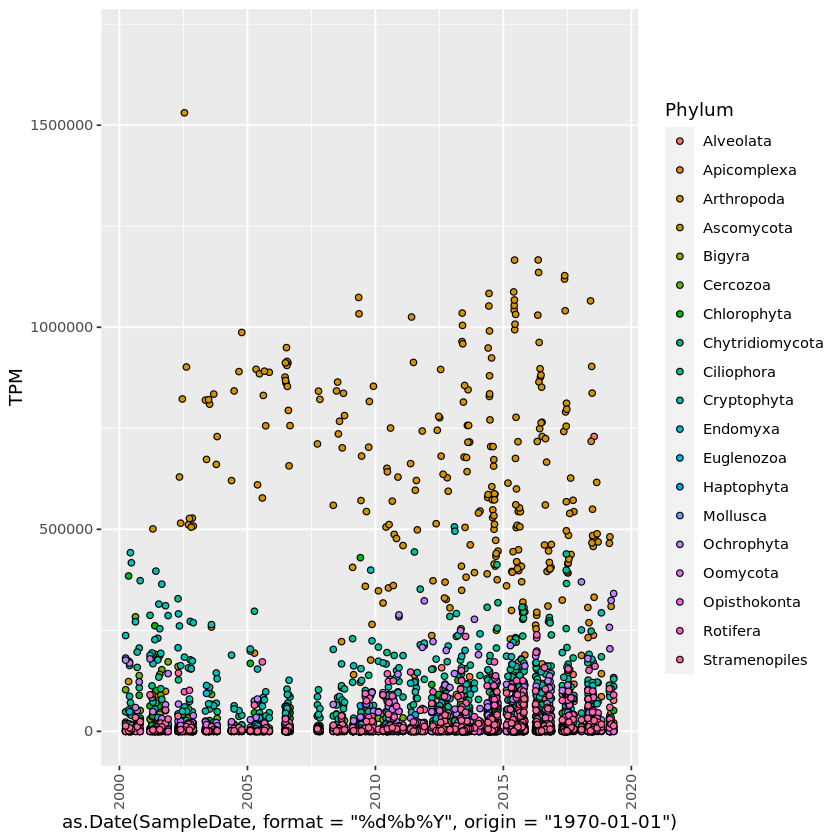

In [5]:
ggplot(sam_with_meta_filt %>% 
       dplyr::left_join(data_tree_euk,by=c("Label")) %>%
       dplyr::group_by(Phylum,SampleDate) %>% dplyr::summarize(TPM = sum(TPM)) %>% 
       dplyr::filter(!is.na(SampleDate) & !is.na(Phylum)))  + 
    geom_point(aes(x=as.Date(SampleDate,format="%d%b%Y",origin="1970-01-01"),
                   y = TPM, fill = Phylum), pch = 21)+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [6]:
distinct_phyla <- sort(c(unique(data_tree_euk$Phylum),c("Bacterial")))
phylum_distinct_cols <- c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', 'gray', '#911eb4', 
                   '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                   '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')

`summarise()` has
grouped output by
'Phylum'. You can
override using the
`.groups` argument.
Warning message:
“Removed 19 rows containing missing values (geom_point).”


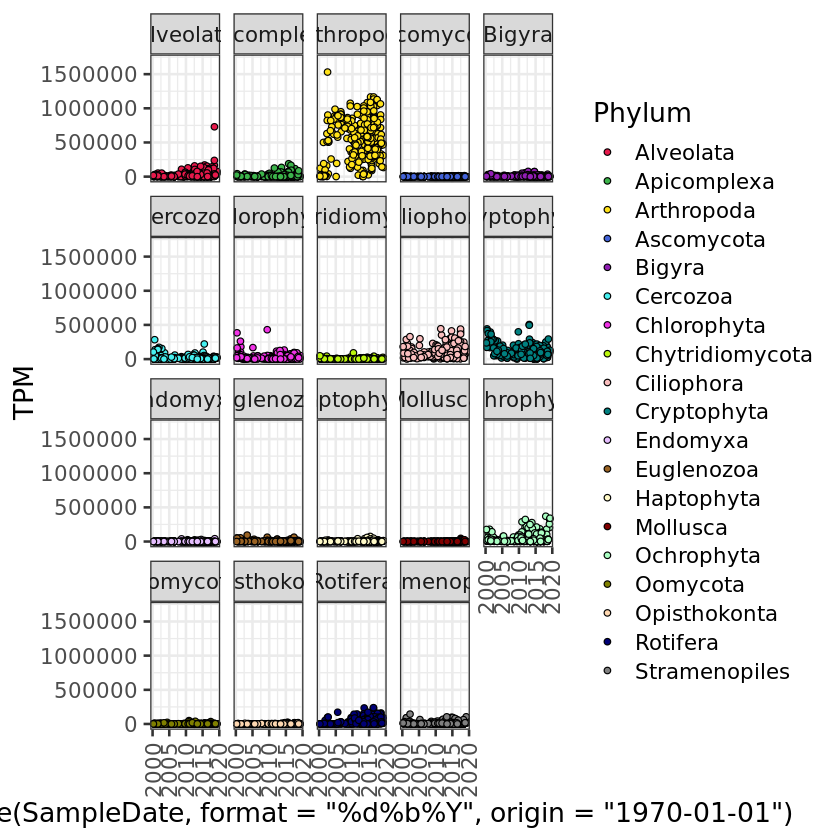

In [7]:
ggplot(sam_with_meta_filt %>% 
       dplyr::left_join(data_tree_euk,by=c("Label")) %>%
       dplyr::group_by(Phylum,SampleDate) %>% dplyr::summarize(TPM = sum(TPM)) %>% 
       dplyr::filter(!is.na(SampleDate) & !is.na(Phylum)))  + 
    geom_point(aes(x=as.Date(SampleDate,format="%d%b%Y",origin="1970-01-01"),
                   y = TPM, fill = Phylum), pch = 21)+ theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_fill_manual(values=phylum_distinct_cols,breaks=distinct_phyla) + facet_wrap(~Phylum)

In [8]:
pivoted_abundance = sam_with_meta_filt %>% dplyr::filter(Label %in% unlist(data_tree_euk$Label)) %>% 
     dplyr::bind_rows(sam_with_meta_bact_filt %>%
                      dplyr::filter(Label %in% unlist(data_tree_bact$Label))) %>%
     dplyr::distinct(Label,SampleDate,TPM) %>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    tidyr::pivot_wider(id_cols=SampleDate,names_from=Label,values_from=TPM,values_fn=max)

In [9]:
correlations <- Hmisc::rcorr(as.matrix(pivoted_abundance %>% dplyr::select(-SampleDate)),
                             type="pearson")

In [10]:
corr_pvals <- as.data.frame(correlations$P) %>% 
                dplyr::select(dplyr::starts_with("ME")) %>%
                tibble::rownames_to_column("Seq1") %>%
                tidyr::pivot_longer(cols=starts_with("ME"),
                                    names_to = "Seq2",values_to="P.vals")

In [11]:
FDR = 0.25
significant_correlations = corr_pvals %>% 
    dplyr::mutate(P.vals = dplyr::case_when(is.na(P.vals) ~ 10,
                                            TRUE ~ P.vals)) %>%
    arrange(P.vals) %>%
    dplyr::mutate(PValRank=c(1:nrow(.))) %>%
    dplyr::mutate(Corrected = PValRank / nrow(corr_pvals %>% dplyr::filter(Seq1!=Seq2)) * FDR) %>%
    dplyr::filter(((P.vals < 0.05) & (Corrected < 0.05)) | (Seq1==Seq2))

In [12]:
corr_coefs <- as.data.frame(correlations$r) %>% 
                dplyr::select(dplyr::starts_with("ME")) %>%
                tibble::rownames_to_column("Seq1") %>%
                tidyr::pivot_longer(cols=starts_with("ME"),
                                    names_to = "Seq2",values_to="CorrCoef")

In [13]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          1.0                         
year           2021                        
month          05                          
day            18                          
svn rev        80317                       
language       R                           
version.string R version 4.1.0 (2021-05-18)
nickname       Camp Pontanezen             

In [14]:
head(bact_layout_frame %>% dplyr::filter(mag=="MEND-TF-16S-1086"))

ERROR: Error in dplyr::filter(., mag == "MEND-TF-16S-1086"): object 'bact_layout_frame' not found


In [15]:
sort(extra_nodes_bact)

ERROR: Error in sort(extra_nodes_bact): object 'extra_nodes_bact' not found


Joining, by =
c("Seq1", "Seq2")
Joining, by =
c("Seq1", "Seq2")
Joining, by =
"Label"


            .tail            .head P.vals PValRank    Corrected  CorrCoef
1  MEND-TF-16S-28  MEND-TF-16S-971      0      527 0.0003641495 0.5529910
2  MEND-TF-16S-83 MEND-TF-16S-1008      0      534 0.0003689864 0.9198013
3  MEND-TF-16S-83  MEND-TF-16S-637      0      537 0.0003710593 0.5200859
4  MEND-TF-16S-83  MEND-TF-16S-972      0      538 0.0003717503 0.5193511
5  MEND-TF-16S-83 MEND-TF-16S-1000      0      539 0.0003724413 0.5058966
6 MEND-TF-16S-103  MEND-TF-16S-982      0      544 0.0003758962 0.5398113
          Seq2_res        Seq1_res             Order1         Phylum1  Domain1
1  MEND-TF-16S-971  MEND-TF-16S-28         Bacillales      Firmicutes Bacteria
2 MEND-TF-16S-1008  MEND-TF-16S-83     Spirochaetales    Spirochaetes Bacteria
3  MEND-TF-16S-637  MEND-TF-16S-83     Spirochaetales    Spirochaetes Bacteria
4  MEND-TF-16S-972  MEND-TF-16S-83     Spirochaetales    Spirochaetes Bacteria
5 MEND-TF-16S-1000  MEND-TF-16S-83     Spirochaetales    Spirochaetes Bacteria
6  MEND-

Joining, by =
c("Seq1", "Seq2")
Joining, by =
"Label"


           .tail           .head P.vals PValRank    Corrected  CorrCoef
1  MEND-TF-18S-1 MEND-TF-18S-309      0        1 6.909857e-07 0.9811613
2 MEND-TF-18S-10 MEND-TF-18S-131      0       10 6.909857e-06 0.7506260
3 MEND-TF-18S-19  MEND-TF-18S-23      0       11 7.600842e-06 0.6702491
4 MEND-TF-18S-23  MEND-TF-18S-19      0       12 8.291828e-06 0.6702491
5 MEND-TF-18S-29 MEND-TF-18S-133      0       20 1.381971e-05 0.5988927
6 MEND-TF-18S-29 MEND-TF-18S-233      0       22 1.520168e-05 0.5275081
         Seq2_res       Seq1_res                    Order1    Phylum1   Domain1
1 MEND-TF-18S-309  MEND-TF-18S-1               Bicosoecida     Bigyra Eukaryota
2 MEND-TF-18S-131 MEND-TF-18S-10               Bicosoecida     Bigyra Eukaryota
3  MEND-TF-18S-23 MEND-TF-18S-19               Diplostraca Arthropoda Eukaryota
4  MEND-TF-18S-19 MEND-TF-18S-23               Diplostraca Arthropoda Eukaryota
5 MEND-TF-18S-133 MEND-TF-18S-29 Ciliophora incertae sedis Ciliophora Eukaryota
6 MEND-TF-18S-23

Adding missing
grouping variables:
`Domain`,
`community`
Joining, by =
c("mag", "Domain",
"community")
Joining, by =
c("Seq1", "Seq2")
Joining, by =
"Label"


           .tail            .head P.vals PValRank    Corrected  CorrCoef
1  MEND-TF-18S-1  MEND-TF-16S-235      0        2 1.381971e-06 0.6925829
2  MEND-TF-18S-1 MEND-TF-16S-1050      0        3 2.072957e-06 0.7303914
3  MEND-TF-18S-1  MEND-TF-16S-679      0        6 4.145914e-06 0.5204989
4 MEND-TF-18S-23  MEND-TF-16S-610      0       13 8.982814e-06 0.5258364
5 MEND-TF-18S-23  MEND-TF-16S-687      0       15 1.036479e-05 0.5067372
6 MEND-TF-18S-23 MEND-TF-16S-1634      0       19 1.312873e-05 0.5189302
          Seq2_res       Seq1_res      Order1    Phylum1   Domain1
1  MEND-TF-16S-235  MEND-TF-18S-1 Bicosoecida     Bigyra Eukaryota
2 MEND-TF-16S-1050  MEND-TF-18S-1 Bicosoecida     Bigyra Eukaryota
3  MEND-TF-16S-679  MEND-TF-18S-1 Bicosoecida     Bigyra Eukaryota
4  MEND-TF-16S-610 MEND-TF-18S-23 Diplostraca Arthropoda Eukaryota
5  MEND-TF-16S-687 MEND-TF-18S-23 Diplostraca Arthropoda Eukaryota
6 MEND-TF-16S-1634 MEND-TF-18S-23 Diplostraca Arthropoda Eukaryota
              Order2

Adding missing
grouping variables:
`Domain`,
`community`
Joining, by =
c("mag", "Domain",
"community")


List of 10
 $ axis.title.x    : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.title.y    : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.text.x     : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.text.y     : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.ticks      : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ panel.background: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ panel.border    : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ panel.grid.major: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ panel.grid.minor: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ plot.background : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi T

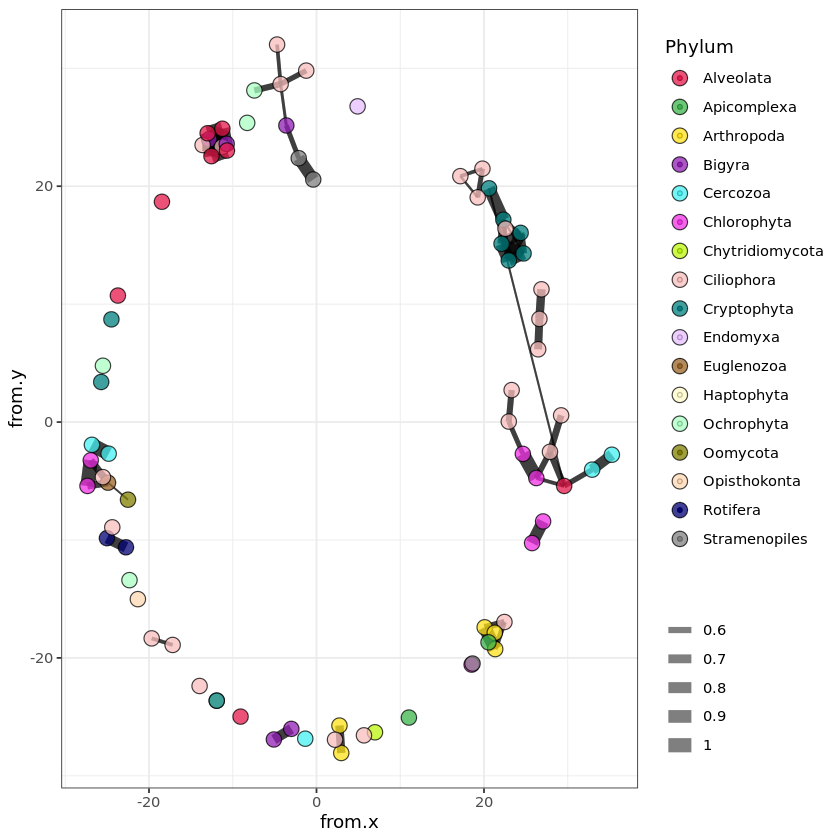

In [37]:
cutoff = 0.5

funct_sapply <- function(x,input) {
    return(grepl(input,x))
}

distinct_cols=c("#458034",
"#c46be1",
"#69c957",
"#8151c2",
"#b0bf33",
"#5c71df",
"#4da02e",
"#d84cb1",
"#46bd76",
"#a3459d",
"#829f34",
"#d44385",
"#42c9b2",
"#da3d5c",
"#3db9cc",
"#d64a2f",
"#519ad3",
"#dd9736",
"#5b5ea3",
"#c0aa41",
"#c086d4",
"#5c6922",
"#9096dd",
"#c3632d",
"#68b78a",
"#984a74",
"#a3bb71",
"#de83b2",
"#367d4c",
"#a54646",
"#2b7f63",
"#df7d78",
"#8e8d47",
"#d99c6c",
"#8d642a")
## Add in the nodes that have any kind of bact-euk connection first ##
euk_bact_conn = significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((grepl("16S",Seq1) & grepl("18S",Seq2)) | 
                  (grepl("16S",Seq2) & grepl("18S",Seq1))) %>% dplyr::filter(CorrCoef > cutoff)
extra_nodes = c(unique(c(euk_bact_conn$Seq1,euk_bact_conn$Seq2)))
extra_nodes_euk = extra_nodes[unlist(sapply(extra_nodes,funct_sapply,"18S"))]
extra_nodes_bact = extra_nodes[unlist(sapply(extra_nodes,funct_sapply,"16S"))]
                  
# read nodes
v = data_tree_euk %>% dplyr::bind_rows(data_tree_bact) %>%
    dplyr::select(Label,Domain,Phylum,Class,Order,Family,Genus,Species) %>%
    dplyr::distinct()

# read edges
e = significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((Seq1!=Seq2) | ((Seq1==Seq2) & (Seq1 %in% extra_nodes_bact)))%>%
    dplyr::filter((grepl("16S",Seq1) & grepl("16S",Seq2)) | ((Seq1 %in% extra_nodes_bact) & 
                  (Seq2 %in% extra_nodes_bact)))%>%
    dplyr::distinct() %>%
    dplyr::filter(CorrCoef > cutoff) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Domain1"="Domain")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Domain2"="Domain")) %>%
    dplyr::mutate(Seq2_res = Seq2,Seq1_res = Seq1)  %>% 
    dplyr::mutate(Seq1 = dplyr::case_when(Domain1 == "Bacteria" ~ Seq1,
                                           TRUE ~ Seq2),
                  Seq2 = dplyr::case_when(Domain1 == "Bacteria" ~ Seq2_res,
                                           TRUE ~ Seq1_res)) %>% dplyr::select(-Domain1,-Domain2) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Order1"="Order","Domain1"="Domain","Phylum1"="Phylum")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Order2"="Order","Domain2"="Domain","Phylum2"="Phylum"))

make_network <- function(e,v,layout="fr") {
    net = network::network(e %>% dplyr::mutate(weight=CorrCoef),multiple=TRUE,loops=TRUE)

    refactored_graph <- graph_from_data_frame(data.frame(net),
                                              directed = FALSE, vertices = NULL)

    V(refactored_graph)$type <- grepl("18S",V(refactored_graph)$name) #the second column of edges is TRUE type

    layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
    if (layout == "circular") {
        layout_gr <- as.data.frame(layout_in_circle(refactored_graph))
    } else if (layout == "bipartite") {
        layout_gr <- as.data.frame(layout_as_bipartite(refactored_graph))
    }

    corr_communities <- cluster_louvain(refactored_graph,weight=data.frame(net)$CorrCoef)

    set_vertex_attr(refactored_graph, "clustermembership",
                    index = V(refactored_graph),
                    membership(corr_communities))
    set_vertex_attr(refactored_graph, "classification",
                    index = V(refactored_graph),
                    (v %>% dplyr::right_join(data.frame("Label"=V(refactored_graph)$name)))$Phylum)


    edge_df <- data.frame(net)
    print(head(edge_df))
    edge_df <- edge_df %>% dplyr::select(-Order1,-Order2) %>% 
        dplyr::left_join(v %>% dplyr::select(Label,Domain,Order,Class),
                                            by=c(".head"="Label")) %>%
        dplyr::rename(c("Dom1"="Domain","Order1"="Order","Class1"="Class")) %>%
        dplyr::left_join(v %>% dplyr::select(Label,Domain,Order,Class),by=c(".tail"="Label")) %>%
        dplyr::rename(c("Dom2"="Domain","Order2"="Order","Class2"="Class"))

    # Add the MAG labels
    #layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
    layout_gr$mag <- V(refactored_graph)$name
    layout_gr$community <- membership(corr_communities)

    # Add the euk-prok labels
    edge_df_inform <- edge_df %>% dplyr::select(.head,Dom1) %>% 
                        dplyr::rename(c("mag"=".head","class"="Dom1")) %>%
                        dplyr::bind_rows(edge_df %>% dplyr::select(.tail,Dom2) %>% 
                                         dplyr::rename(c("mag"=".tail","class"="Dom2")))
    layout_gr = layout_gr %>% dplyr::left_join(v,by=c("mag"="Label")) %>%
        dplyr::rename(c("classification"="Phylum")) %>%
        dplyr::mutate(classification=dplyr::case_when(Domain == "Bacteria" ~ "Bacterial",
                                                      TRUE ~ classification))
    #layout_gr$community <- membership(corr_communities)

    layout_gr <- layout_gr %>% 
                        dplyr::mutate("degree" = as.numeric(as.character(igraph::degree(refactored_graph,
                                                                                      v = layout_gr$mag))))

    layout_gr = layout_gr %>% 
                dplyr::select(V1,V2,mag,classification,Domain,Class,Order,Family,community,degree)
    layout_gr <- layout_gr %>% dplyr::distinct()

    edge_df$from.x <- layout_gr$V1[match(edge_df$.head, layout_gr$mag)]  #  match the from locations from the node data.frame we previously connected
    edge_df$from.y <- layout_gr$V2[match(edge_df$.head, layout_gr$mag)]
    edge_df$to.x <- layout_gr$V1[match(edge_df$.tail, layout_gr$mag)]  #  match the to locations from the node data.frame we previously connected
    edge_df$to.y <- layout_gr$V2[match(edge_df$.tail, layout_gr$mag)]

    layout_gr_classes = layout_gr
    return(list(edge_df,layout_gr))
}

returned_frame = make_network(e,v) #,layout="circular")
bact_edge_frame = returned_frame[[1]]
bact_layout_frame = returned_frame[[2]] 

# read edges
e = significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((Seq1!=Seq2) | ((Seq1==Seq2) & (Seq1 %in% extra_nodes_euk)))%>%
    dplyr::filter((grepl("18S",Seq1) & grepl("18S",Seq2))| ((Seq1 %in% extra_nodes_euk) & 
                  (Seq2 %in% extra_nodes_euk)))%>%
    dplyr::filter((CorrCoef > cutoff))%>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Domain1"="Domain")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Domain2"="Domain")) %>%
    dplyr::mutate(Seq2_res = Seq2,Seq1_res = Seq1)  %>% 
    dplyr::mutate(Seq1 = dplyr::case_when(Domain1 == "Eukaryota" ~ Seq1,
                                           TRUE ~ Seq2),
                  Seq2 = dplyr::case_when(Domain1 == "Eukaryota" ~ Seq2_res,
                                           TRUE ~ Seq1_res)) %>% dplyr::select(-Domain1,-Domain2) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Order1"="Order","Domain1"="Domain","Phylum1"="Phylum")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Order2"="Order","Domain2"="Domain","Phylum2"="Phylum"))

# read nodes
v = data_tree_euk %>% dplyr::bind_rows(data_tree_bact) %>%
    dplyr::select(Label,Domain,Phylum,Class,Order,Family,Genus,Species) %>%
    dplyr::distinct()

h_meas = mean(bact_layout_frame$V1) #0 # x coord of center
k_meas = mean(bact_layout_frame$V2) #4 # y coord of center
# radius for euks
r_euk = 27

# radius for bact
r_bac = 1

returned_frame = make_network(e,v)
euk_edge_frame = returned_frame[[1]]
euk_layout_frame = returned_frame[[2]] 

community_means = euk_layout_frame %>%
    dplyr::group_by(Domain,community) %>%
    dplyr::mutate(mean_cluster_centers = mean(V1,na.rm=TRUE),
                  mean_cluster_y = mean(V2,na.rm=TRUE))
euk_layout_frame = euk_layout_frame %>%
    dplyr::left_join(community_means %>% dplyr::select(mag,mean_cluster_centers,mean_cluster_y)) %>%
    dplyr::group_by(Domain) %>%
    dplyr::mutate(total_x_distance = sqrt((max(mean_cluster_centers) - 
                                           min(mean_cluster_centers))^2)) %>%
    dplyr::mutate(mod_V1 = mean_cluster_centers / total_x_distance * 360) %>% # angular measurement
    dplyr::ungroup() %>%
    dplyr::mutate(r = dplyr::case_when(Domain == "Eukaryota" ~ r_euk,
                                       TRUE ~ r_bac),
                  add_extra = dplyr::case_when(Domain == "Eukaryota" ~ r_euk*2,
                                       TRUE ~ 0),
                  h = h_meas, k = k_meas,
                  circle_x = dplyr::case_when(Domain == "Eukaryota" ~ r_euk*cos(mod_V1*pi/180) + h_meas + 
                                              (V1-mean_cluster_centers)*3,
                                              TRUE ~ V1),
                  circle_y = dplyr::case_when(Domain == "Eukaryota" ~ r_euk*sin(mod_V1*pi/180) + k_meas + 
                                              (V2-mean_cluster_y)*3,
                                              TRUE ~ V2)) %>%
    dplyr::mutate(V1=circle_x,V2=circle_y)


all_nodes = c(unique(euk_layout_frame$mag), unique(bact_layout_frame$mag))
# read edges
e = significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((grepl("16S",Seq1) & grepl("18S",Seq2)) | 
                  (grepl("16S",Seq2) & grepl("18S",Seq1))) %>% 
    dplyr::filter(CorrCoef > cutoff) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Domain1"="Domain")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Domain2"="Domain")) %>%
    dplyr::mutate(Seq2_res = Seq2,Seq1_res = Seq1)  %>% 
    dplyr::mutate(Seq1 = dplyr::case_when(Domain1 == "Eukaryota" ~ Seq1,
                                           TRUE ~ Seq2),
                  Seq2 = dplyr::case_when(Domain1 == "Eukaryota" ~ Seq2_res,
                                           TRUE ~ Seq1_res)) %>% dplyr::select(-Domain1,-Domain2) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Order1"="Order","Domain1"="Domain","Phylum1"="Phylum")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Phylum,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Order2"="Order","Domain2"="Domain","Phylum2"="Phylum"))

# read nodes
v = data_tree_euk %>% dplyr::bind_rows(data_tree_bact) %>%
    dplyr::select(Label,Domain,Phylum,Class,Order,Family,Genus,Species) %>%
    dplyr::distinct()

spacer_euk=max(c(abs(euk_edge_frame$from.x),abs(euk_edge_frame$to.x)))
spacer_bact=max(c(bact_edge_frame$from.x,bact_edge_frame$to.x))

spacer_euk=(max(c(abs(euk_edge_frame$from.x),abs(euk_edge_frame$to.x))))*2
spacer_bact=max(c(abs(bact_edge_frame$from.x),abs(bact_edge_frame$to.x)))

scaling_bact=max(c(abs(bact_edge_frame$from.y),abs(bact_edge_frame$to.y)))
scaling_euk=max(c(abs(euk_edge_frame$from.y),abs(euk_edge_frame$to.y)))

scaling_bact=max(c(abs(bact_edge_frame$from.y),abs(bact_edge_frame$to.y)))
scaling_euk=(max(c(abs(euk_edge_frame$from.y),abs(euk_edge_frame$to.y))) + 
    abs(min(c(euk_edge_frame$from.y,euk_edge_frame$to.y))))*2

spacer_bact_y=max(c(bact_edge_frame$from.y,bact_edge_frame$to.y))

returned_frame = make_network(e,v)
euk_bact_edge_frame = returned_frame[[1]] #%>% dplyr::filter((.head %in% all_nodes) & (.tail %in% all_nodes))
euk_bact_layout_frame = returned_frame[[2]]
# circle center for euks & bacteria
h_meas = 0 # x coord of center
k_meas = 0 # y coord of center
# radius for euks
#r_euk = 4

# radius for bact
#r_bac = 3


community_means = euk_bact_layout_frame %>%
    dplyr::select(-V1,-V2) %>% dplyr::left_join((euk_layout_frame %>%
                                                 dplyr::bind_rows(bact_layout_frame) %>%
                                                 dplyr::select(mag,V1,V2)),
                                                by="mag") %>%
    dplyr::group_by(Domain,community) %>%
    dplyr::mutate(mean_cluster_centers = mean(V1,na.rm=TRUE),
                  mean_cluster_y = mean(V2,na.rm=TRUE))
euk_bact_layout_frame = euk_bact_layout_frame %>% dplyr::ungroup() %>%
    dplyr::select(-V1,-V2) %>% dplyr::left_join((euk_layout_frame %>%
                                                 dplyr::bind_rows(bact_layout_frame) %>%
                                                 dplyr::distinct() %>%
                                                 dplyr::select(mag,V1,V2)),
                                                by="mag") %>%
    dplyr::left_join(community_means %>% dplyr::select(mag,mean_cluster_centers,mean_cluster_y)) %>%
    dplyr::group_by(Domain) %>%
    dplyr::mutate(total_x_distance = sqrt((max(mean_cluster_centers) - 
                                           min(mean_cluster_centers))^2),na.rm=TRUE) %>%
    dplyr::mutate(mod_V1 = mean_cluster_centers / total_x_distance * 360) %>% # angular measurement
    dplyr::ungroup() %>%
    dplyr::mutate(r = dplyr::case_when(Domain == "Eukaryota" ~ r_euk,
                                       TRUE ~ r_bac),
                  add_extra = dplyr::case_when(Domain == "Eukaryota" ~ r_euk*2,
                                       TRUE ~ 0),
                  h = h_meas, k = k_meas) %>%
    dplyr::mutate(circle_x = V1,
                  circle_y = V2) %>% 
    dplyr::mutate(V1 = circle_x, V2 = circle_y)


bact_layout_frame = bact_layout_frame %>%
    dplyr::left_join(euk_bact_layout_frame %>% dplyr::select(mag), by = "mag")

euk_bact_edge_frame = euk_bact_edge_frame %>%
    dplyr::select(-from.x,-to.x,-from.y,-to.y) %>%
    dplyr::left_join(euk_bact_layout_frame %>% 
                     dplyr::select(mag,circle_x,circle_y,classification),
                     by = c(".head"="mag")) %>%
    dplyr::rename(c("LinkPhylum"="classification")) %>%
    dplyr::mutate(BaseColor="Euk-Bact") %>%
    dplyr::rename(c("from.x"="circle_x","from.y"="circle_y")) %>%
    dplyr::left_join(euk_bact_layout_frame %>% dplyr::select(mag,circle_x,circle_y),
                     by = c(".tail"="mag")) %>%
    dplyr::rename(c("to.x"="circle_x","to.y"="circle_y")) %>%
    dplyr::filter(.head != .tail)

bact_communities=na.omit(unique(euk_bact_edge_frame$community))
bact_layout_frame = bact_layout_frame 
bact_edge_frame = bact_edge_frame %>% dplyr::filter((.head %in% bact_layout_frame$mag) | 
                                                    (.tail %in% bact_layout_frame$mag))

combined_edge_frame = bact_edge_frame %>%
    dplyr::select(-from.x,-from.y,-to.x,-to.y) %>%
    dplyr::left_join(bact_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".tail"="mag")) %>%
    dplyr::mutate(to.x=V1,to.y=V2) %>%
    dplyr::select(-V1,-V2) %>%
    dplyr::left_join(bact_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".head"="mag")) %>%
    dplyr::mutate(from.x=V1,from.y=V2) %>%
    dplyr::select(-V1,-V2) %>%
    dplyr::bind_rows(euk_edge_frame %>%
    dplyr::select(-from.x,-from.y,-to.x,-to.y) %>%
    dplyr::left_join(euk_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".tail"="mag")) %>%
    dplyr::mutate(to.x=V1,to.y=V2)%>%
    dplyr::select(-V1,-V2) %>%
    dplyr::left_join(euk_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".head"="mag")) %>%
    dplyr::mutate(from.x=V1,from.y=V2)) %>%
    dplyr::select(-V1,-V2) %>%
    dplyr::bind_rows(euk_bact_edge_frame %>% 
                     dplyr::select(.head,.tail,weight,Phylum1,CorrCoef,BaseColor,
                                   from.x,from.y,to.x,to.y,LinkPhylum))

euk_edge_frame = euk_edge_frame %>%
    dplyr::select(-from.x,-from.y,-to.x,-to.y) %>%
    dplyr::left_join(euk_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".tail"="mag")) %>%
    dplyr::mutate(to.x=V1,to.y=V2)%>%
    dplyr::select(-V1,-V2) %>%
    dplyr::left_join(euk_layout_frame %>% dplyr::select(mag,V1,V2),
                     by=c(".head"="mag")) %>%
    dplyr::mutate(from.x=V1,from.y=V2)

ggplot() +
    geom_segment(data=euk_edge_frame %>%
                 dplyr::filter(weight > 0),aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef),
                 alpha=0.5) +
        scale_color_manual(name = "Phylum", values = phylum_distinct_cols,breaks=distinct_phyla) +
        geom_point(data=euk_layout_frame%>%dplyr::filter(classification=="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=classification),
                   size=1,pch=21) +
        geom_point(data=euk_layout_frame%>%dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=classification),
                   size=4,pch=21,alpha=0.75) +
        theme_bw() +
        new_scale_color() +
        scale_color_manual(name = "Community", values = distinct_cols) + 
        scale_fill_manual(name = "Phylum", values = phylum_distinct_cols,breaks=distinct_phyla) + 
        scale_size(range = c(0, 4),labels=c("0.1","0.2","0.3",
                                            "0.4","0.5","0.6",
                                            "0.7","0.8","0.9","1"),
                   breaks=c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),name="") 


        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank())

In [38]:
high_abundance_bact = (combined_edge_frame %>% dplyr::mutate(Col1=pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail),
                                      Col2=pmax(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE) %>%
    dplyr::filter(grepl("18S",.tail)) %>%
    dplyr::group_by(.head) %>% dplyr::tally() %>% dplyr::filter(n >= 4))$.head

In [39]:
all_comm = ggplot(euk_bact_layout_frame %>% dplyr::group_by(community,classification) %>% dplyr::tally()) + 
    geom_bar(aes(x=community,y=n,fill=classification),stat="identity") +
    scale_fill_manual(values=phylum_distinct_cols,breaks=distinct_phyla) + theme_bw(base_size=16)

bac_comm = ggplot(euk_bact_layout_frame %>% dplyr::filter(Domain == "Bacteria") %>%
                  dplyr::group_by(community,Class) %>% dplyr::tally()) + 
    geom_tile(aes(x=factor(community),fill=n,y=Class),stat="identity") +
    scale_fill_gradient(low="light blue", high="magenta") + theme_bw(base_size=16)

euk_comm = ggplot(euk_bact_layout_frame %>% dplyr::filter(Domain == "Eukaryota") %>%
                  dplyr::group_by(community,Class) %>% dplyr::tally()) + 
    geom_tile(aes(x=factor(community),fill=n,y=Class),stat="identity") +
    scale_fill_gradient(low="light blue", high="magenta") + theme_bw(base_size=16)

In [40]:
high_corr_coef_bact = (combined_edge_frame %>% dplyr::mutate(Col1=pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail),
                                      Col2=pmax(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE) %>%
    dplyr::filter(grepl("18S",.tail)) %>%
    dplyr::group_by(.head,CorrCoef) %>% dplyr::tally() %>% dplyr::filter(CorrCoef > 0.7))$.head

Joining, by =
c("Domain2",
"from.x", "from.y",
".head")
Warning message:
“Ignoring unknown aesthetics: shape”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



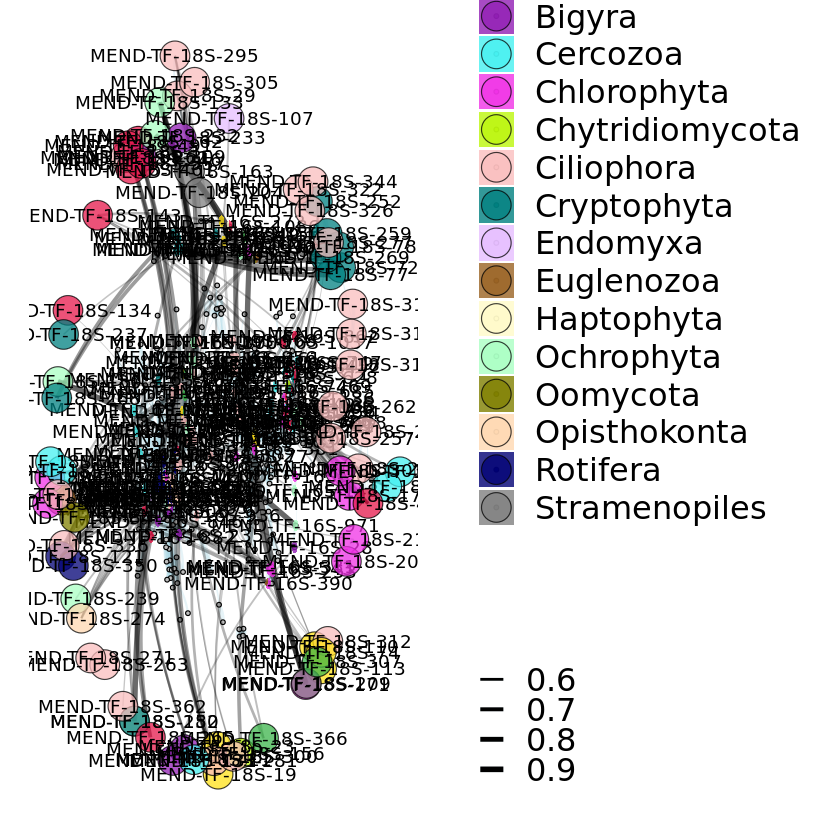

In [70]:
cluster_centers = bact_layout_frame %>% dplyr::group_by(community) %>% 
                    dplyr::summarize(mean_x = mean(V1),mean_y=mean(V2),n_points=n())
pie_frame_tots = euk_bact_edge_frame %>% dplyr::filter(Domain2=="Bacteria") %>%
                             dplyr::group_by(Domain2,from.x,from.y,.head) %>%
                             dplyr::tally() %>% dplyr::rename(c("Total"="n"))
pie_frame = euk_bact_edge_frame %>% dplyr::filter(Domain2=="Bacteria") %>%
                             dplyr::group_by(Phylum1,Domain2,from.x,from.y,.head) %>%
                             dplyr::tally() %>%
                             dplyr::left_join(pie_frame_tots) %>% dplyr::mutate(n=n/Total*0.5) %>%
                             dplyr::mutate(Radius=0.5) %>%
                             tidyr::pivot_wider(id_cols=c("from.x","from.y",".head","Radius"),
                                                                   names_from="Phylum1",
                                                                   values_from="n") 
pie_frame[is.na(pie_frame)] = 0
network_main = ggplot() +
      #ggforce::geom_circle(data = cluster_centers, aes(x0 = mean_x, y0 = mean_y, r = (n_points)^(1/(2.5)),
      #                                               fill = factor(community)), col = NA, alpha = 0.5) +
      #geom_label(data = cluster_centers, aes(x = mean_x, y = mean_y, label=community)) +
      #scale_fill_manual(values=distinct_cols,name="Community",
      #                  guide=guide_legend(ncol=3)) + new_scale_fill() +
      geom_curve(data= combined_edge_frame[!duplicated(cbind(pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail), 
                                      pmax(combined_edge_frame$.head,
                                           combined_edge_frame$.tail))),]  %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor!="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor!="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef),
                 alpha=0.3,curvature=0.1,color="light blue") +
        geom_point(data=bact_layout_frame%>%
                   dplyr::filter(classification=="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=classification),
                   size=1,pch=21) +
      geom_curve(data= combined_edge_frame %>% dplyr::mutate(Col1=pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail),
                                      Col2=pmax(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE)%>%
                 dplyr::filter(!is.na(BaseColor)) %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor=="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor=="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef,alpha=CorrCoef),
                 curvature=0.1, color="black") +scale_alpha(range = c(0.2, 0.7)) + 
        geom_scatterpie(data=pie_frame,
                        aes(x=from.x,y=from.y,group=".head",r=Radius),
                    cols=setdiff(distinct_phyla,c("Ascomycota","Bacterial","Mollusca")), 
                        color=NA, alpha=.8) + 
        geom_text(data=pie_frame,
                        aes(x=from.x,y=from.y,label=.head)) + 
        geom_point(data=euk_layout_frame%>%
                   dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=classification),
                   size=8,pch=21,alpha=0.75) +
        scale_fill_manual(name = "Phylum", values = phylum_distinct_cols,breaks=distinct_phyla) + 
        new_scale_fill() + 
        scale_color_manual(name="Phylum",values=phylum_distinct_cols,breaks=distinct_phyla) + 
        #scale_colour_gradient(low="blue", high="maroon", name="Correlation\nCoefficient") + 
        new_scale_color() + 
        #geom_point(data=euk_bact_layout_frame %>%
        #               dplyr::left_join(euk_bact_layout_frame %>% dplyr::rename(c("Euk_Bact_Comm"="community"))) %>%
        #               dplyr::filter((classification %in% c("Ciliophora","Ochrophyta")) |
        #                             (mag %in% high_abundance_bact) | (mag %in% high_corr_coef_bact)),
        #                              aes(x=V1,y=V2,fill=Order),
        #           size=5,alpha=0.75,pch=22) +
        scale_fill_manual(values=distinct_cols) + 
        theme_bw(base_size=24) +
        geom_text(data=euk_layout_frame%>%
                   dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      label=mag)) +
        new_scale_color() +
        scale_size(range = c(0,1.75),labels=c("0.1","0.2","0.3",
                                            "0.4","0.5","0.6",
                                            "0.7","0.8","0.9","1"),
                   breaks=c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),name="") +
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border = element_blank(), #element_rect(colour = "black", fill=NA, size=3),
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank()) + guides(fill=guide_legend(ncol=2))
network_main
ggsave("../../figures/euk-bact-interaction-net.pdf",width=18,height=14,units="in")

Joining, by =
c("Domain2",
"from.x", "from.y",
".head")


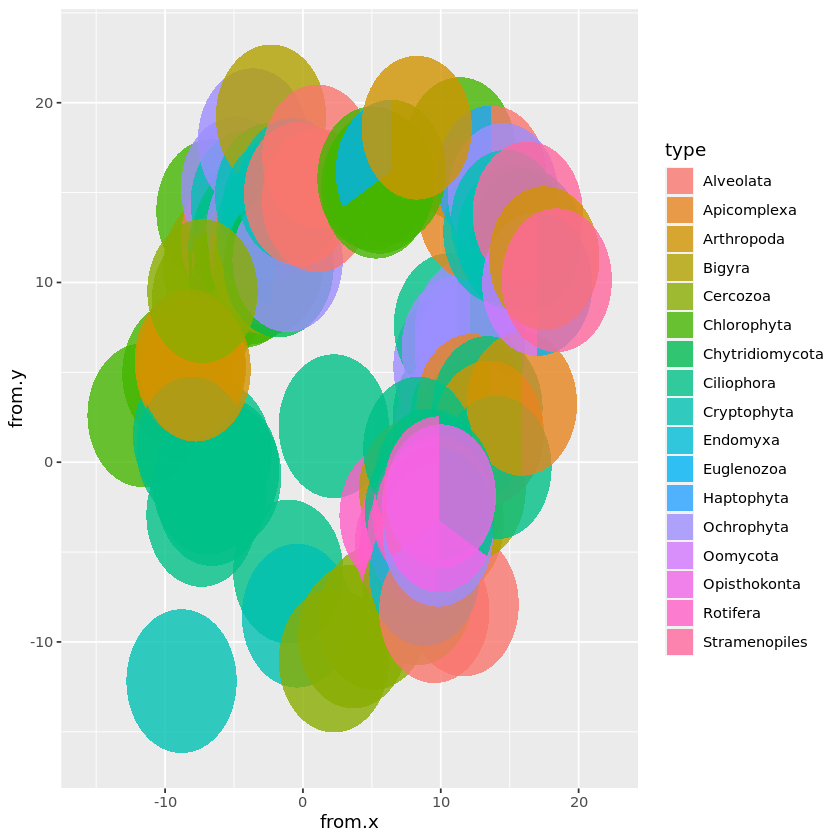

In [29]:
pie_frame_tots = euk_bact_edge_frame %>% dplyr::filter(Domain2=="Bacteria") %>%
                             dplyr::group_by(Domain2,from.x,from.y,.head) %>%
                             dplyr::tally() %>% dplyr::rename(c("Total"="n"))
pie_frame = euk_bact_edge_frame %>% dplyr::filter(Domain2=="Bacteria") %>%
                             dplyr::group_by(Phylum1,Domain2,from.x,from.y,.head) %>%
                             dplyr::tally() %>%
                             dplyr::left_join(pie_frame_tots) %>% dplyr::mutate(n=n/Total*4) %>%
                             dplyr::mutate(Radius=4) %>%
                             tidyr::pivot_wider(id_cols=c("from.x","from.y",".head","Radius"),
                                                                   names_from="Phylum1",
                                                                   values_from="n") 
pie_frame[is.na(pie_frame)] = 0

ggplot() +  geom_scatterpie(data=pie_frame,
                        aes(x=from.x,y=from.y,group=".head",r=Radius),
                    cols=setdiff(distinct_phyla,c("Ascomycota","Bacterial","Mollusca")), 
                        color=NA, alpha=.8)

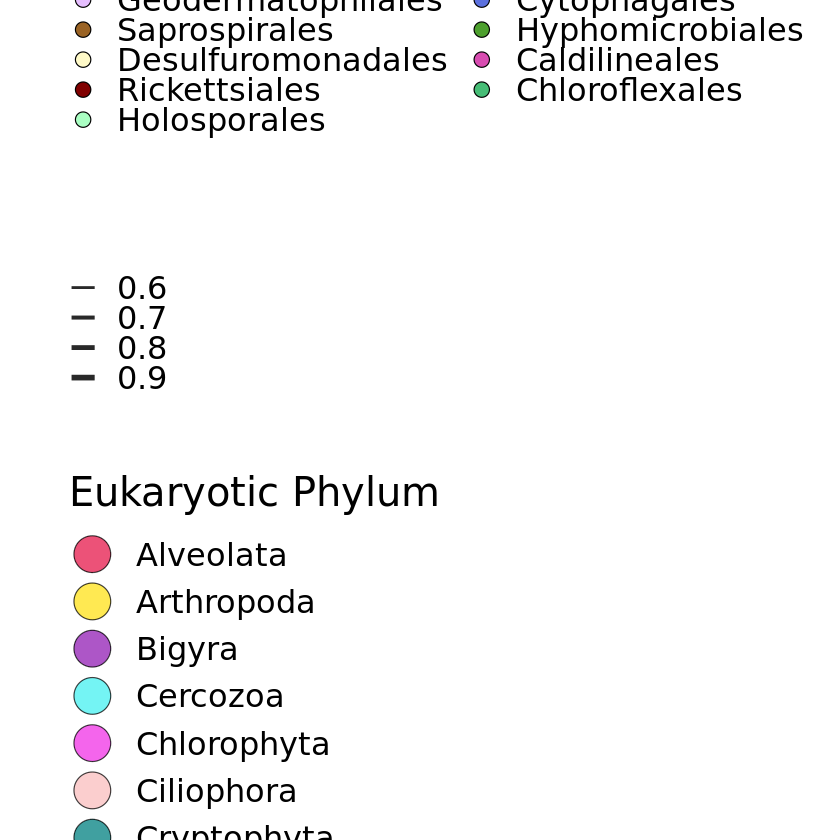

In [30]:
combined_frame_red = combined_edge_frame[!duplicated(cbind(pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail), 
                                      pmax(combined_edge_frame$.head,
                                           combined_edge_frame$.tail))),]
alveolate_only = combined_frame_red %>% dplyr::ungroup() %>% dplyr::filter((grepl("Ciliophora",Phylum1)) | 
                                                          (grepl("Ciliophora",Phylum2)) | 
                                                           (grepl("Cercozoa",Phylum1)) | 
                                                           (grepl("Cercozoa",Phylum2))| 
                                                           (grepl("Alveolata",Phylum1)) | 
                                                           (grepl("Alveolata",Phylum2)))


bacterial_order_cols = c(setdiff(phylum_distinct_cols,distinct_cols),distinct_cols)
bacterial_orders = unique((bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)))$Order)
network_alveolate = ggplot() +
    new_scale_fill() + 
    geom_point(data=euk_layout_frame%>%
               dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
               dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                  shape=Domain,
                                  fill=classification),
               size=10,pch=21,alpha=0.75) +
    scale_fill_manual(values = phylum_distinct_cols,breaks=distinct_phyla,name="Eukaryotic Phylum") + 
    new_scale_fill() + 
      geom_curve(data= alveolate_only[!duplicated(cbind(pmin(alveolate_only$.head, 
                                           alveolate_only$.tail), 
                                      pmax(alveolate_only$.head,
                                           alveolate_only$.tail))),]  %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor!="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor!="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef),
                 alpha=0.8,curvature=0.1,color="gray") +
      geom_curve(data= alveolate_only %>% dplyr::mutate(Col1=pmin(alveolate_only$.head, 
                                           alveolate_only$.tail),
                                      Col2=pmax(alveolate_only$.head, 
                                           alveolate_only$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE)%>%
                 dplyr::filter(!is.na(BaseColor)) %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor=="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor=="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef,color=CorrCoef),
                 alpha=0.8,curvature=0.1)+
    geom_point(data=bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
                   dplyr::filter(classification=="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=Order),
                   size=4,pch=21)+
    scale_fill_manual(values = bacterial_order_cols,breaks=bacterial_orders,name="Bacterial Order") + 
        scale_colour_gradient(low="blue", high="maroon", name="Correlation\nCoefficient") + 
        theme_bw(base_size=24) +
        new_scale_color() +
        scale_size(range = c(0,1.75),labels=c("0.1","0.2","0.3",
                                            "0.4","0.5","0.6",
                                            "0.7","0.8","0.9","1"),
                   breaks=c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),name="")+
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank()) + guides(fill=guide_legend(ncol=2))
network_alveolate
ggsave("../../figures/ciliate-only.pdf",width=15,height=15,units="in")

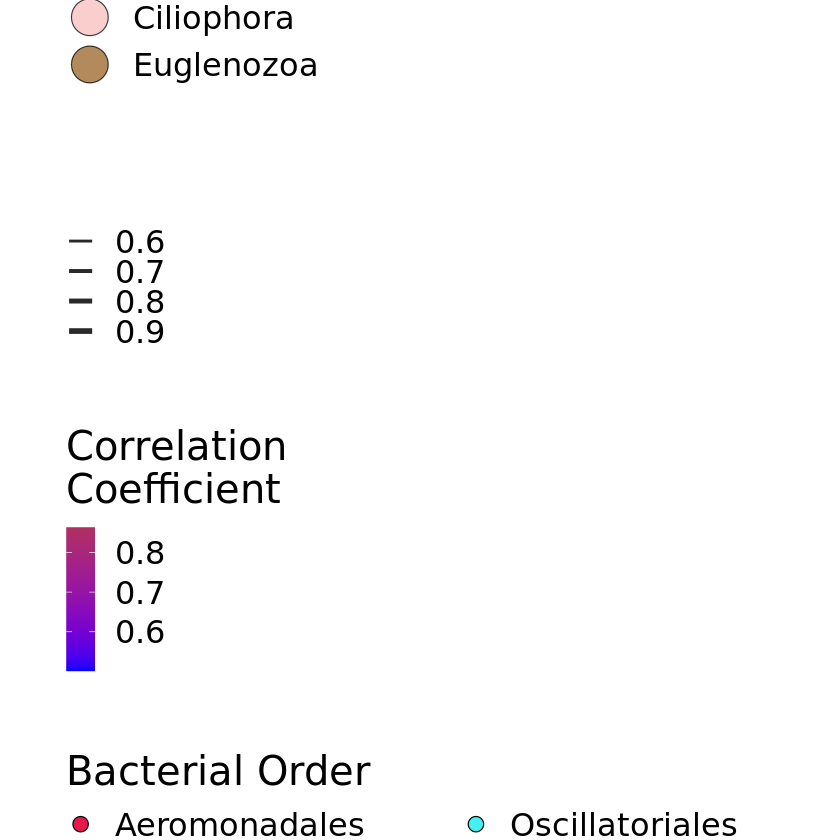

In [23]:
combined_frame_red = combined_edge_frame[!duplicated(cbind(pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail), 
                                      pmax(combined_edge_frame$.head,
                                           combined_edge_frame$.tail))),]
alveolate_only = combined_frame_red %>% dplyr::ungroup() %>% dplyr::filter((grepl("Chlorophyta",Phylum1)) | 
                                                          (grepl("Chlorophyta",Phylum2)))


bacterial_order_cols = setdiff(phylum_distinct_cols,distinct_cols)
bacterial_orders = unique((bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)))$Order)
network_alveolate = ggplot() +
    new_scale_fill() + 
    geom_point(data=euk_layout_frame%>%
               dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
               dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                  shape=Domain,
                                  fill=classification),
               size=10,pch=21,alpha=0.75) +
    scale_fill_manual(values = phylum_distinct_cols,breaks=distinct_phyla,name="Eukaryotic Phylum") + 
    new_scale_fill() + 
      geom_curve(data= alveolate_only[!duplicated(cbind(pmin(alveolate_only$.head, 
                                           alveolate_only$.tail), 
                                      pmax(alveolate_only$.head,
                                           alveolate_only$.tail))),]  %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor!="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor!="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef),
                 alpha=0.8,curvature=0.1,color="gray") +
      geom_curve(data= alveolate_only %>% dplyr::mutate(Col1=pmin(alveolate_only$.head, 
                                           alveolate_only$.tail),
                                      Col2=pmax(alveolate_only$.head, 
                                           alveolate_only$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE)%>%
                 dplyr::filter(!is.na(BaseColor)) %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor=="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor=="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef,color=CorrCoef),
                 alpha=0.8,curvature=0.1)+
    geom_point(data=bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
                   dplyr::filter(classification=="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=Order),
                   size=4,pch=21)+
    scale_fill_manual(values = bacterial_order_cols,breaks=bacterial_orders,name="Bacterial Order") + 
        scale_colour_gradient(low="blue", high="maroon", name="Correlation\nCoefficient") + 
        theme_bw(base_size=24) +
        new_scale_color() +
        scale_size(range = c(0,1.75),labels=c("0.1","0.2","0.3",
                                            "0.4","0.5","0.6",
                                            "0.7","0.8","0.9","1"),
                   breaks=c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),name="")+
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank()) + guides(fill=guide_legend(ncol=2))
network_alveolate
ggsave("../../figures/chlorophyte-only.pdf",width=15,height=15,units="in")

In [160]:
alveolate_only

.tail,.head,P.vals,PValRank,Corrected,CorrCoef,Phylum1,Domain1,Phylum2,Domain2,Seq2_res,Seq1_res,weight,Dom1,Order1,Class1,Dom2,Order2,Class2,to.x,to.y,from.x,from.y,BaseColor,LinkPhylum
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MEND-TF-18S-29,MEND-TF-18S-133,0,20,1.381971e-05,0.5988927,Ciliophora,Eukaryota,Ochrophyta,Eukaryota,MEND-TF-18S-133,MEND-TF-18S-29,0.5988927,Eukaryota,Aulacoseirales,Coscinodiscophyceae,Eukaryota,Ciliophora incertae sedis,Ciliophora incertae sedis,-5.723638,-27.68057,-5.381833,-25.5678674,NA,NA
MEND-TF-18S-133,MEND-TF-16S-83,NA,NA,NA,0.7495212,Ochrophyta,NA,NA,NA,NA,NA,0.7495212,NA,NA,NA,NA,NA,NA,-5.381833,-25.56787,-8.835271,1.1172961,Euk-Bact,Bacterial
MEND-TF-18S-133,MEND-TF-16S-103,NA,NA,NA,0.5239673,Ochrophyta,NA,NA,NA,NA,NA,0.5239673,NA,NA,NA,NA,NA,NA,-5.381833,-25.56787,-7.748363,-3.7237306,Euk-Bact,Bacterial
MEND-TF-18S-133,MEND-TF-16S-370,NA,NA,NA,0.7159230,Ochrophyta,NA,NA,NA,NA,NA,0.7159230,NA,NA,NA,NA,NA,NA,-5.381833,-25.56787,-11.267188,1.2296117,Euk-Bact,Bacterial
MEND-TF-18S-133,MEND-TF-16S-1008,NA,NA,NA,0.8698393,Ochrophyta,NA,NA,NA,NA,NA,0.8698393,NA,NA,NA,NA,NA,NA,-5.381833,-25.56787,-10.005504,0.9280401,Euk-Bact,Bacterial
MEND-TF-18S-133,MEND-TF-16S-972,NA,NA,NA,0.5528253,Ochrophyta,NA,NA,NA,NA,NA,0.5528253,NA,NA,NA,NA,NA,NA,-5.381833,-25.56787,-8.859983,0.1375733,Euk-Bact,Bacterial


In [25]:
data_tree_bact %>% dplyr::filter(Label == "MEND-TF-16S-1086")

V1,parent,node,branch.length,label,isTip,x,y,branch,angle,⋯,clustnum,seqlen,percid,plus,a,b,aln,target,Label,Metagenome
<int>,<int>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
229,875,229,0.1149813,Ga0334999_0005130SSU_rRNA_bacteria,TRUE,5.522113,342,5.464622,192.375,⋯,1086,1482,*,*,*,*,*,*,MEND-TF-16S-1086,MG


In [53]:
head(euk_layout_frame)

V1,V2,mag,classification,Domain,Class,Order,Family,community,degree,mean_cluster_centers,mean_cluster_y,total_x_distance,mod_V1,r,add_extra,h,k,circle_x,circle_y
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<membrshp>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-12.832201,23.97823,MEND-TF-18S-1,Bigyra,Eukaryota,Opalozoa,Bicosoecida,Bicosoecidae,1,4,18.74315,17.606691,14.10318,478.4404,27,54,1.082417,0.0423862,-12.832201,23.97823
-3.006283,-26.01613,MEND-TF-18S-10,Bigyra,Eukaryota,Opalozoa,Bicosoecida,Bicosoecidae,2,2,24.25150,7.825808,14.10318,619.0476,27,54,1.082417,0.0423862,-3.006283,-26.01613
2.954270,-28.06168,MEND-TF-18S-19,Arthropoda,Eukaryota,Branchiopoda,Diplostraca,Daphniidae,3,2,24.82741,9.837611,14.10318,633.7481,27,54,1.082417,0.0423862,2.954270,-28.06168
2.740591,-25.73805,MEND-TF-18S-23,Arthropoda,Eukaryota,Branchiopoda,Diplostraca,Daphniidae,3,4,24.82741,9.837611,14.10318,633.7481,27,54,1.082417,0.0423862,2.740591,-25.73805
-4.281832,28.65957,MEND-TF-18S-29,Ciliophora,Eukaryota,Ciliophora incertae sedis,Ciliophora incertae sedis,Ciliophora incertae sedis,4,10,18.00272,13.522823,14.10318,459.5400,27,54,1.082417,0.0423862,-4.281832,28.65957
-24.891177,-5.14141,MEND-TF-18S-38,Euglenozoa,Eukaryota,Euglenida,Spirocuta,Euglenophyceae,5,8,21.58466,7.009364,14.10318,550.9732,27,54,1.082417,0.0423862,-24.891177,-5.14141


Warning message:
“Ignoring unknown aesthetics: shape”


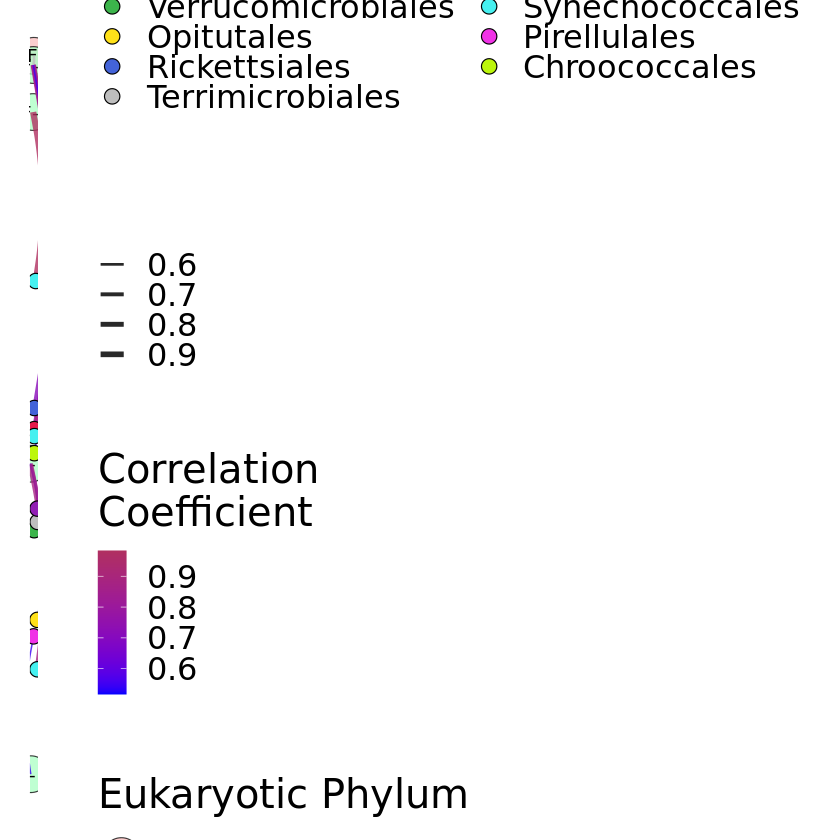

In [54]:
combined_frame_red = combined_edge_frame[!duplicated(cbind(pmin(combined_edge_frame$.head, 
                                           combined_edge_frame$.tail), 
                                      pmax(combined_edge_frame$.head,
                                           combined_edge_frame$.tail))),]
alveolate_only = combined_frame_red %>% dplyr::ungroup() %>% dplyr::filter((grepl("Ochrophyta",Phylum1)) | 
                                                          (grepl("Ochrophyta",Phylum2)))


bacterial_order_cols = setdiff(phylum_distinct_cols,distinct_cols)
bacterial_orders = unique((bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)))$Order)
network_alveolate = ggplot() +
    new_scale_fill() + 
    geom_point(data=euk_layout_frame%>%
               dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
               dplyr::filter(classification!="Bacterial"),aes(x=V1,y=V2,
                                  shape=Domain,
                                  fill=classification),
               size=10,pch=21,alpha=0.75) +
    scale_fill_manual(values = phylum_distinct_cols,breaks=distinct_phyla,name="Eukaryotic Phylum") + 
    new_scale_fill() + 
      geom_curve(data= alveolate_only[!duplicated(cbind(pmin(alveolate_only$.head, 
                                           alveolate_only$.tail), 
                                      pmax(alveolate_only$.head,
                                           alveolate_only$.tail))),]  %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor!="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor!="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef),
                 alpha=0.8,curvature=0.1,color="gray") +
      geom_curve(data= alveolate_only %>% dplyr::mutate(Col1=pmin(alveolate_only$.head, 
                                           alveolate_only$.tail),
                                      Col2=pmax(alveolate_only$.head, 
                                           alveolate_only$.tail)) %>%
                 dplyr::distinct(Col1,Col2,BaseColor,.keep_all=TRUE)%>%
                 dplyr::filter(!is.na(BaseColor)) %>%
                 dplyr::filter(weight > 0) %>%
                 dplyr::mutate(BaseColor = dplyr::case_when(!is.na(BaseColor) ~ BaseColor,
                                                            ((Dom1=="Bacteria") & 
                                                             (Dom2=="Bacteria"))~ "Bact-Bact",
                                                            ((Dom1=="Eukaryota") & 
                                                             (Dom2=="Eukaryota"))~ "Euk-Euk")) %>%
                 dplyr::filter(BaseColor=="Euk-Bact") %>%
                 dplyr::mutate(BaseColor=factor(BaseColor,
                               levels=c("Bact-Bact","Euk-Euk","Euk-Bact"))) %>%
                 dplyr::filter((.tail!=.head) & (BaseColor=="Euk-Bact")),
                                  aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=CorrCoef,color=CorrCoef),
                 alpha=0.8,curvature=0.1)+
    geom_point(data=bact_layout_frame%>%
                   dplyr::filter((mag %in% alveolate_only$.tail) | (mag %in% alveolate_only$.head)) %>%
                   dplyr::filter(classification=="Bacterial"),aes(x=V1,y=V2,
                                      shape=Domain,
                                      fill=Order),
                   size=4,pch=21)+
    scale_fill_manual(values = bacterial_order_cols,breaks=bacterial_orders,name="Bacterial Order") + 
        scale_colour_gradient(low="blue", high="maroon", name="Correlation\nCoefficient") + 
        theme_bw(base_size=24) +
        new_scale_color() +
        scale_size(range = c(0,1.75),labels=c("0.1","0.2","0.3",
                                            "0.4","0.5","0.6",
                                            "0.7","0.8","0.9","1"),
                   breaks=c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),name="")+
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank()) + guides(fill=guide_legend(ncol=2))
network_alveolate
ggsave("../../figures/ochrophyte-only.pdf",width=15,height=15,units="in")

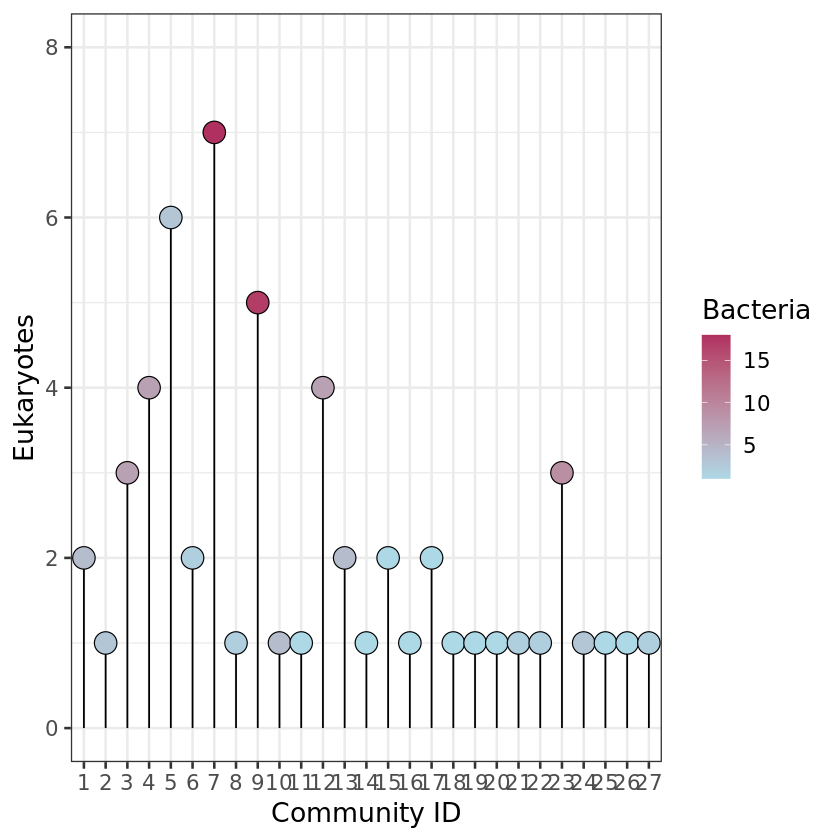

In [128]:
ggplot(euk_bact_layout_frame %>%
                  dplyr::group_by(community,Domain) %>% dplyr::tally() %>%
    tidyr::pivot_wider(id_cols=c("community"),names_from="Domain",values_from="n")) + 
    #geom_abline(aes(intercept=0,slope=1),linetype="dotted") +
    geom_segment(aes(x=factor(community),xend=community,y=0,yend=Eukaryota)) + 
    geom_point(aes(x = factor(community), y = Eukaryota, fill = (Bacteria)),pch=21,size=6) + 
    #geom_point(aes(x = Bacteria, y = Eukaryota),fill="light gray", pch=21,size=3) +
               #position = position_jitter(seed = 10,width=2)) + 
    #geom_text(aes(x = Bacteria, y = Eukaryota, label=community),size=2,color="black") + 
             #position=position_jitter(seed=10,width=2)) + 
    theme_bw(base_size=16) + xlab("Community ID") + ylab("Eukaryotes") + 
    scale_fill_gradient(low="light blue", high = "maroon",name="Bacteria") + ylim(c(0,8))

In [83]:
significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((grepl("16S",Seq1) & grepl("18S",Seq2)) | 
                  (grepl("16S",Seq2) & grepl("18S",Seq1)) | 
                                           (Seq1==Seq2)) %>%
    dplyr::filter(CorrCoef > 0.5) %>%
    dplyr::left_join(data_tree_euk,by = c("Seq1"="Label")) %>%
    dplyr::distinct(Seq1,Seq2,.keep_all=TRUE) %>% 
    dplyr::group_by(Seq1,Seq2,Phylum,Order,Class,CorrCoef,Corrected) %>% dplyr::tally() %>%
    dplyr::mutate(n=n-1) %>% dplyr::filter(Phylum == "Alveolata") %>%
    dplyr::left_join(bact_layout_frame %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="classification")),
                     by=c("Seq2"="mag")) %>%
    dplyr::filter(Seq1!=Seq2)

Joining, by =
c("Seq1", "Seq2")


Seq1,Seq2,Phylum,Order,Class.x,CorrCoef,Corrected,n,V1,V2,BactPhylum,Domain,Class.y,BactOrder,BactFamily,community,degree
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<membrshp>,<dbl>
MEND-TF-18S-134,MEND-TF-16S-921,Alveolata,Thoracosphaerales,Dinophyceae,0.5069400,0.0001112487,0,-4.317679,-1.063882,Bacterial,Bacteria,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,3,22
MEND-TF-18S-143,MEND-TF-16S-1086,Alveolata,Gymnodiniales,Dinophyceae,0.5840866,0.0001188495,0,4.975825,17.750818,Bacterial,Bacteria,,Synechococcales,Chamaesiphonaceae,26,2
MEND-TF-18S-143,MEND-TF-16S-452,Alveolata,Gymnodiniales,Dinophyceae,0.5128816,0.0001153946,0,16.944419,6.043011,Bacterial,Bacteria,Chitinophagia,Chitinophagales,Chitinophagaceae,1,18
MEND-TF-18S-143,MEND-TF-16S-628,Alveolata,Gymnodiniales,Dinophyceae,0.5877135,0.0001160856,0,16.410856,5.142722,Bacterial,Bacteria,Acidimicrobiia,Acidimicrobiales,Acidimicrobiaceae,1,24
MEND-TF-18S-143,MEND-TF-16S-685,Alveolata,Gymnodiniales,Dinophyceae,0.5196453,0.0001167766,0,15.843784,3.961509,Bacterial,Bacteria,Actinomycetia,Geodermatophilales,Geodermatophilaceae,1,38
MEND-TF-18S-143,MEND-TF-16S-862,Alveolata,Gymnodiniales,Dinophyceae,0.5393507,0.0001181586,0,16.583106,8.541525,Bacterial,Bacteria,Deltaproteobacteria,Desulfuromonadales,Geobacter,1,8
MEND-TF-18S-265,MEND-TF-16S-503,Alveolata,Gymnodiniales,Dinophyceae,0.7042753,0.0002066047,0,-10.078970,-6.062812,Bacterial,Bacteria,Planctomycetia,Pirellulales,Pirellulaceae,4,14
MEND-TF-18S-265,MEND-TF-16S-882,Alveolata,Gymnodiniales,Dinophyceae,0.6522607,0.0002079867,0,-8.963393,-8.232483,Bacterial,Bacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,4,10
MEND-TF-18S-494,MEND-TF-16S-1033,Alveolata,Peridiniales,Dinophyceae,0.6657438,0.0003102526,0,14.890347,2.859313,Bacterial,Bacteria,Alphaproteobacteria,Sphingomonadales,Sphingosinicellaceae,1,22


Joining, by = c("Seq1", "Seq2")



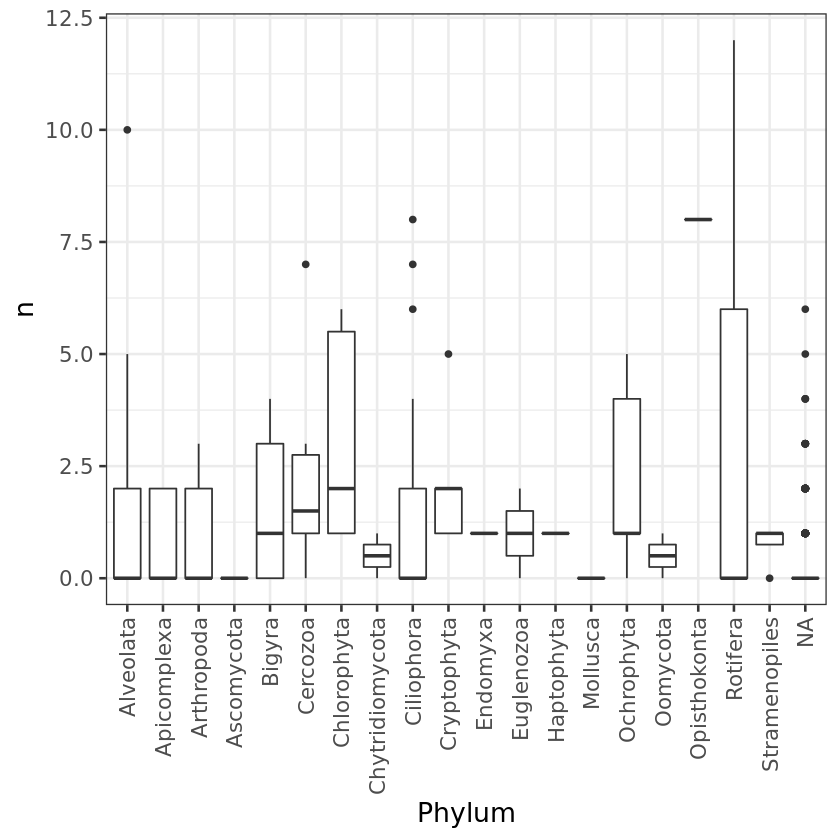

In [273]:
combined_phylum = significant_correlations %>% dplyr::left_join(corr_coefs) %>%
    dplyr::filter((grepl("16S",Seq1) & grepl("18S",Seq2)) | 
                  (grepl("16S",Seq2) & grepl("18S",Seq1)) | 
                                           (Seq1==Seq2)) %>%
    dplyr::filter(CorrCoef > 0.5) %>%
    dplyr::left_join(data_tree_euk,by = c("Seq1"="Label")) %>%
    dplyr::distinct(Seq1,Seq2,.keep_all=TRUE) %>% 
    dplyr::group_by(Seq1,Phylum) %>% dplyr::tally() %>%
    dplyr::mutate(n=n-1)
    #%>% dplyr::ungroup() %>%
    #dplyr::group_by(Phylum) %>% dplyr::summarize(MeanBactAssociates = mean(n),
    #                                              StdBactAssociates = sd(n,na.rm=TRUE))

ggplot(combined_phylum) + geom_boxplot(aes(x=Phylum,y=n)) + theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
ggplot(euk_bact_layout_frame %>%
                  dplyr::group_by(community,Domain) %>% dplyr::tally() %>%
    tidyr::pivot_wider(id_cols=c("community"),names_from="Domain",values_from="n")) + 
    #geom_abline(aes(intercept=0,slope=1),linetype="dotted") +
    geom_segment(aes(x=factor(community),xend=community,y=0,yend=Eukaryota)) + 
    geom_point(aes(x = factor(community), y = Eukaryota, fill = (Bacteria)),pch=21,size=6) + 
    #geom_point(aes(x = Bacteria, y = Eukaryota),fill="light gray", pch=21,size=3) +
               #position = position_jitter(seed = 10,width=2)) + 
    #geom_text(aes(x = Bacteria, y = Eukaryota, label=community),size=2,color="black") + 
             #position=position_jitter(seed=10,width=2)) + 
    theme_bw(base_size=16) + xlab("Community ID") + ylab("Eukaryotes") + 
    scale_fill_gradient(low="light blue", high = "maroon",name="Bacteria") + ylim(c(0,8))

In [129]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

euk_bact_layout_frame %>%
                  dplyr::group_by(community,Order,classification,Domain) %>% dplyr::tally()

community,Order,classification,Domain,n
<membrshp>,<chr>,<chr>,<chr>,<int>
1,Bicosoecida,Bigyra,Eukaryota,2
1,Caulobacterales,Bacterial,Bacteria,1
1,Fimbriimonadales,Bacterial,Bacteria,1
1,Flavobacteriales,Bacterial,Bacteria,1
1,Verrucomicrobiales,Bacterial,Bacteria,1
2,Diplostraca,Arthropoda,Eukaryota,1
2,Micrococcales,Bacterial,Bacteria,3
3,Aulacoseirales,Ochrophyta,Eukaryota,1
3,Chroococcales,Bacterial,Bacteria,1


## Chlorophyte associates

In [274]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Chlorophyta") %>%
    dplyr::left_join(bact_layout_frame %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="classification")),
                     by=c(".head"="mag")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1033,Sphingomonadales,Bacterial,0.5355321,Sphingosinicellaceae,2
MEND-TF-16S-1136,Rhodobacterales,Bacterial,0.5284343,Rhodobacteraceae,2
MEND-TF-16S-120,Chthoniobacterales,Bacterial,0.5212824,Chthoniobacteraceae,2
MEND-TF-16S-120,Chthoniobacterales,Bacterial,0.5288982,Chthoniobacteraceae,2
MEND-TF-16S-1520,Burkholderiales,Bacterial,0.5143772,Comamonadaceae,2
MEND-TF-16S-253,Aeromonadales,Bacterial,0.5698346,Aeromonadaceae,2
MEND-TF-16S-253,Aeromonadales,Bacterial,0.6093877,Aeromonadaceae,2
MEND-TF-16S-331,Moraxellales,Bacterial,0.5613994,Moraxellaceae,2
MEND-TF-16S-331,Moraxellales,Bacterial,0.6041932,Moraxellaceae,2


## Cryptophyta associate

In [46]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Cryptophyta") %>% dplyr::arrange(.tail)

.tail,.head,P.vals,PValRank,Corrected,CorrCoef,Seq2_res,Seq1_res,Phylum1,Domain1,⋯,Class1,Dom2,Order2,Class2,from.x,from.y,LinkPhylum,BaseColor,to.x,to.y
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
MEND-TF-18S-237,MEND-TF-16S-949,0,236,1.630726e-04,0.5316251,MEND-TF-16S-949,MEND-TF-18S-237,Cryptophyta,Eukaryota,⋯,Alphaproteobacteria,Eukaryota,Cyathomonadacea,Cryptophyceae,2.483956,17.109260,Bacterial,Euk-Bact,-24.48905,8.708430
MEND-TF-18S-237,MEND-TF-16S-949,0,4244,2.932543e-03,0.5316251,MEND-TF-18S-237,MEND-TF-16S-949,Cryptophyta,Eukaryota,⋯,Alphaproteobacteria,Eukaryota,Cyathomonadacea,Cryptophyceae,2.483956,17.109260,Bacterial,Euk-Bact,-24.48905,8.708430
MEND-TF-18S-250,MEND-TF-16S-981,0,249,1.720554e-04,0.6088901,MEND-TF-16S-981,MEND-TF-18S-250,Cryptophyta,Eukaryota,⋯,,Eukaryota,Pyrenomonadales,Cryptophyceae,-4.479150,15.791204,Bacterial,Euk-Bact,-11.91310,-23.624398
MEND-TF-18S-250,MEND-TF-16S-1072,0,250,1.727464e-04,0.5037224,MEND-TF-16S-1072,MEND-TF-18S-250,Cryptophyta,Eukaryota,⋯,Alphaproteobacteria,Eukaryota,Pyrenomonadales,Cryptophyceae,-7.640850,4.960649,Bacterial,Euk-Bact,-11.91310,-23.624398
MEND-TF-18S-250,MEND-TF-16S-981,0,4394,3.036191e-03,0.6088901,MEND-TF-18S-250,MEND-TF-16S-981,Cryptophyta,Eukaryota,⋯,,Eukaryota,Pyrenomonadales,Cryptophyceae,-4.479150,15.791204,Bacterial,Euk-Bact,-11.91310,-23.624398
MEND-TF-18S-250,MEND-TF-16S-1072,0,4977,3.439036e-03,0.5037224,MEND-TF-18S-250,MEND-TF-16S-1072,Cryptophyta,Eukaryota,⋯,Alphaproteobacteria,Eukaryota,Pyrenomonadales,Cryptophyceae,-7.640850,4.960649,Bacterial,Euk-Bact,-11.91310,-23.624398
MEND-TF-18S-252,MEND-TF-16S-311,0,255,1.762013e-04,0.5268940,MEND-TF-16S-311,MEND-TF-18S-252,Cryptophyta,Eukaryota,⋯,Planctomycetia,Eukaryota,Kathablepharidacea,Cryptophyceae,14.853250,5.487587,Bacterial,Euk-Bact,20.60030,19.825131
MEND-TF-18S-252,MEND-TF-16S-628,0,256,1.768923e-04,0.5209381,MEND-TF-16S-628,MEND-TF-18S-252,Cryptophyta,Eukaryota,⋯,Acidimicrobiia,Eukaryota,Kathablepharidacea,Cryptophyceae,16.410856,5.142722,Bacterial,Euk-Bact,20.60030,19.825131
MEND-TF-18S-252,MEND-TF-16S-685,0,257,1.775833e-04,0.5925374,MEND-TF-16S-685,MEND-TF-18S-252,Cryptophyta,Eukaryota,⋯,Actinomycetia,Eukaryota,Kathablepharidacea,Cryptophyceae,15.843784,3.961509,Bacterial,Euk-Bact,20.60030,19.825131


In [44]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Cryptophyta") %>%
    dplyr::left_join(bact_layout_frame %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="classification")),
                     by=c(".head"="mag")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1072,Rhodospirillales,Bacterial,0.5037224,Acetobacteraceae,2
MEND-TF-16S-311,Planctomycetales,Bacterial,0.5268940,Planctomycetaceae,2
MEND-TF-16S-628,Acidimicrobiales,Bacterial,0.5209381,Acidimicrobiaceae,2
MEND-TF-16S-685,Geodermatophilales,Bacterial,0.5091901,Geodermatophilaceae,2
MEND-TF-16S-685,Geodermatophilales,Bacterial,0.5925374,Geodermatophilaceae,2
MEND-TF-16S-747,Saprospirales,Bacterial,0.5092489,Haliscomenobacteraceae,2
MEND-TF-16S-819,Saprospirales,Bacterial,0.5341786,Haliscomenobacteraceae,2
MEND-TF-16S-946,Rickettsiales,Bacterial,0.6912874,Rickettsiaceae,2
MEND-TF-16S-949,Hyphomicrobiales,Bacterial,0.5316251,Xanthobacteraceae,2


## Apicomplexan associates

In [137]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Apicomplexa") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1056,Pleurocapsales,Cyanobacteria,0.5726361,Dermocarpellaceae,2
MEND-TF-16S-197,Myxococcales,Proteobacteria,0.5579223,Sorangiineae incertae sedis,2
MEND-TF-16S-425,Silvanigrellales,Proteobacteria,0.5493642,Silvanigrellaceae,2
MEND-TF-16S-637,Blastocatellales,Acidobacteria,0.5945745,Pyrinomonadaceae,2


In [139]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Chytridiomycota")

.tail,.head,P.vals,PValRank,Corrected,CorrCoef,Seq2_res,Seq1_res,Phylum1,Domain1,⋯,Class1,Dom2,Order2,Class2,from.x,from.y,LinkPhylum,BaseColor,to.x,to.y
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
MEND-TF-18S-156,MEND-TF-16S-469,0,174,0.0001202315,0.660392,MEND-TF-16S-469,MEND-TF-18S-156,Chytridiomycota,Eukaryota,⋯,Planctomycetia,Eukaryota,Rhizophydiales,Chytridiomycetes,5.761885,-11.40377,Bacterial,Euk-Bact,23.17972,-14.95902
MEND-TF-18S-156,MEND-TF-16S-469,0,2244,0.0015505719,0.660392,MEND-TF-18S-156,MEND-TF-16S-469,Chytridiomycota,Eukaryota,⋯,Planctomycetia,Eukaryota,Rhizophydiales,Chytridiomycetes,5.761885,-11.40377,Bacterial,Euk-Bact,23.17972,-14.95902


In [138]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Chytridiomycota") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-469,Isosphaerales,Planctomycetes,0.660392,Isosphaeraceae,2


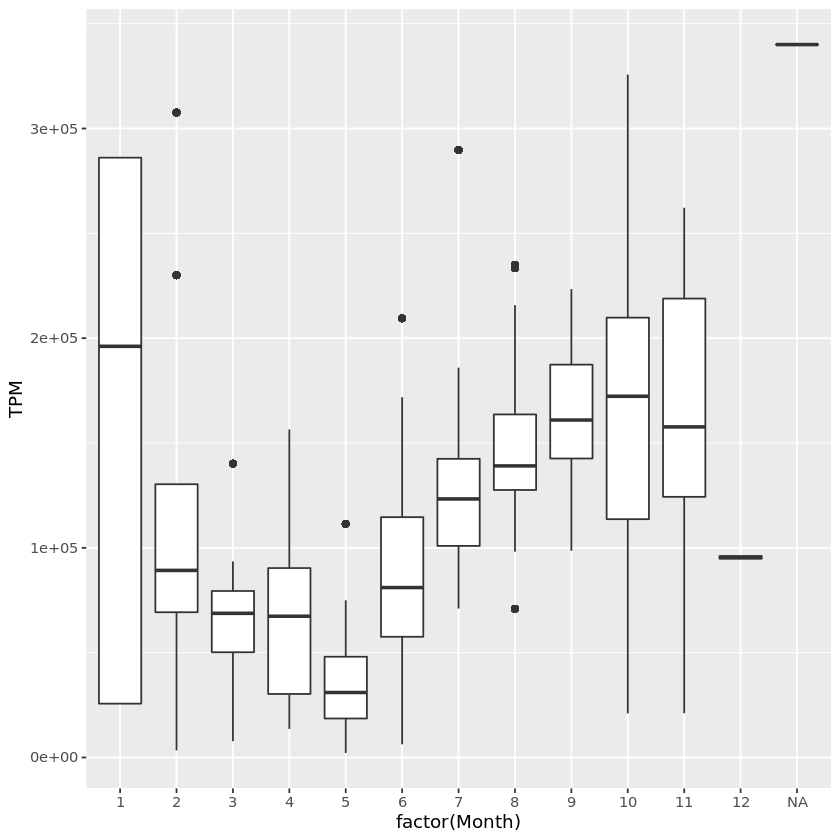

In [152]:
ggplot(sam_with_meta_bact_filt %>% 
       dplyr::left_join(data_tree_bact,by=c("Label")) %>%
       dplyr::filter(Phylum=="Cyanobacteria") %>%
           dplyr::group_by(SampleDate) %>% dplyr::mutate(TPM=sum(TPM)) %>%
       dplyr::mutate(Month = month(as.Date(SampleDate,format="%d%b%Y"))))+ 
    geom_boxplot(aes(x=factor(Month),y=TPM))

Warning message:
“Removed 42 rows containing missing values (geom_point).”


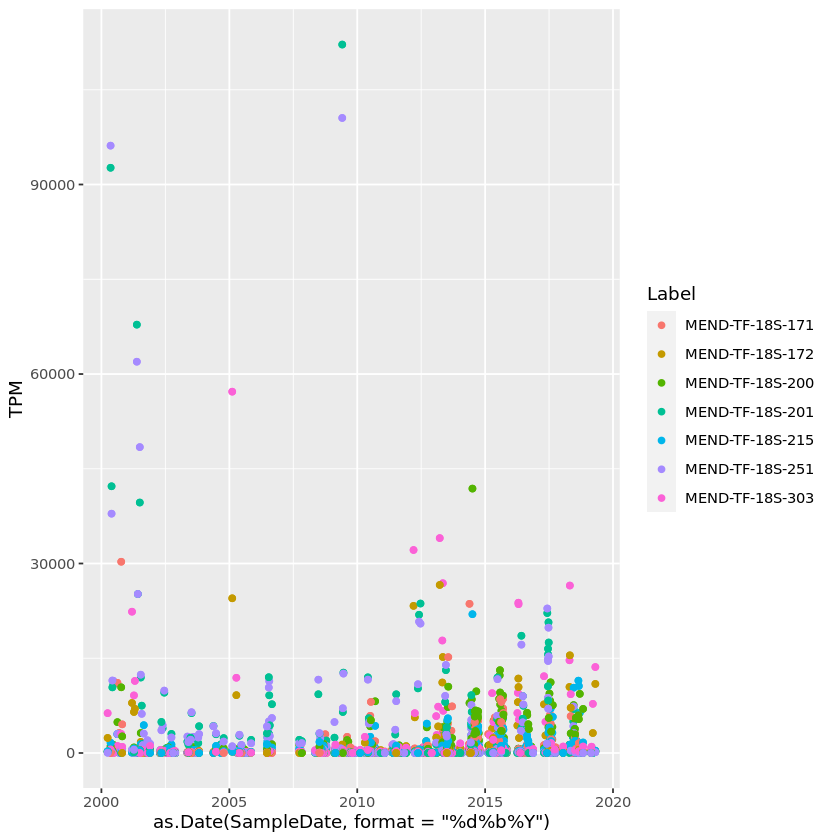

In [161]:
ggplot(sam_with_meta_filt %>% 
       dplyr::left_join(data_tree_euk,by=c("Label")) %>%
       dplyr::filter(Phylum=="Chlorophyta")) +
           #dplyr::group_by(SampleDate) %>% dplyr::mutate(TPM=sum(TPM)) %>%
       #dplyr::mutate(Month = month(as.Date(SampleDate,format="%d%b%Y"))))+ 
    geom_point(aes(x=as.Date(SampleDate,format="%d%b%Y"),y=TPM,color=Label))

Warning message:
“Removed 6 rows containing missing values (geom_point).”


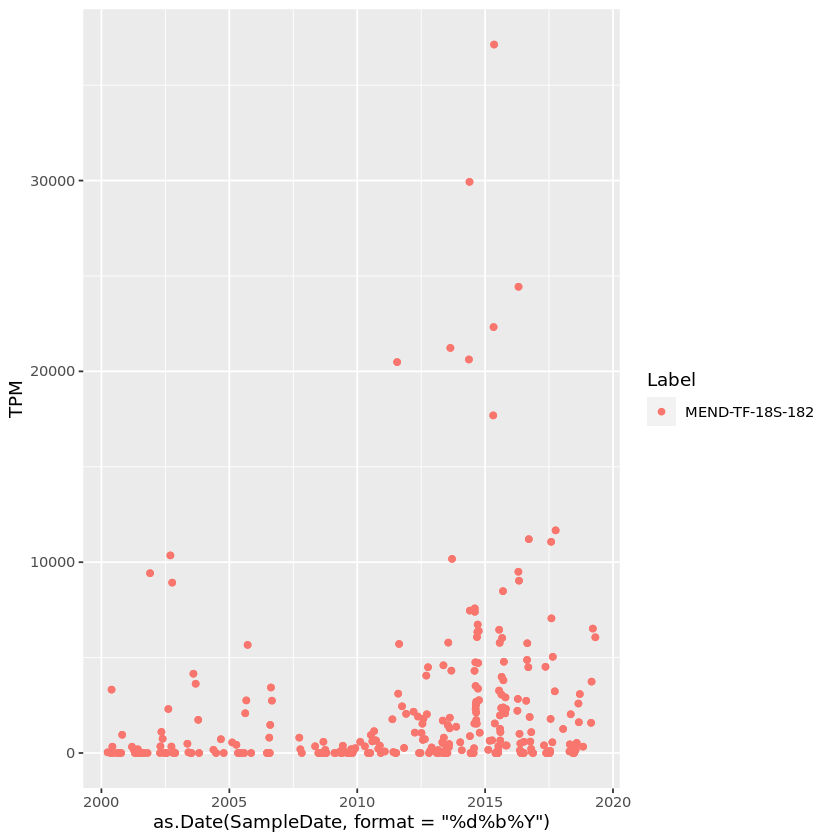

In [162]:
ggplot(sam_with_meta_filt %>% 
       dplyr::left_join(data_tree_euk,by=c("Label")) %>%
       dplyr::filter(Phylum=="Haptophyta")) +
           #dplyr::group_by(SampleDate) %>% dplyr::mutate(TPM=sum(TPM)) %>%
       #dplyr::mutate(Month = month(as.Date(SampleDate,format="%d%b%Y"))))+ 
    geom_point(aes(x=as.Date(SampleDate,format="%d%b%Y"),y=TPM,color=Label))

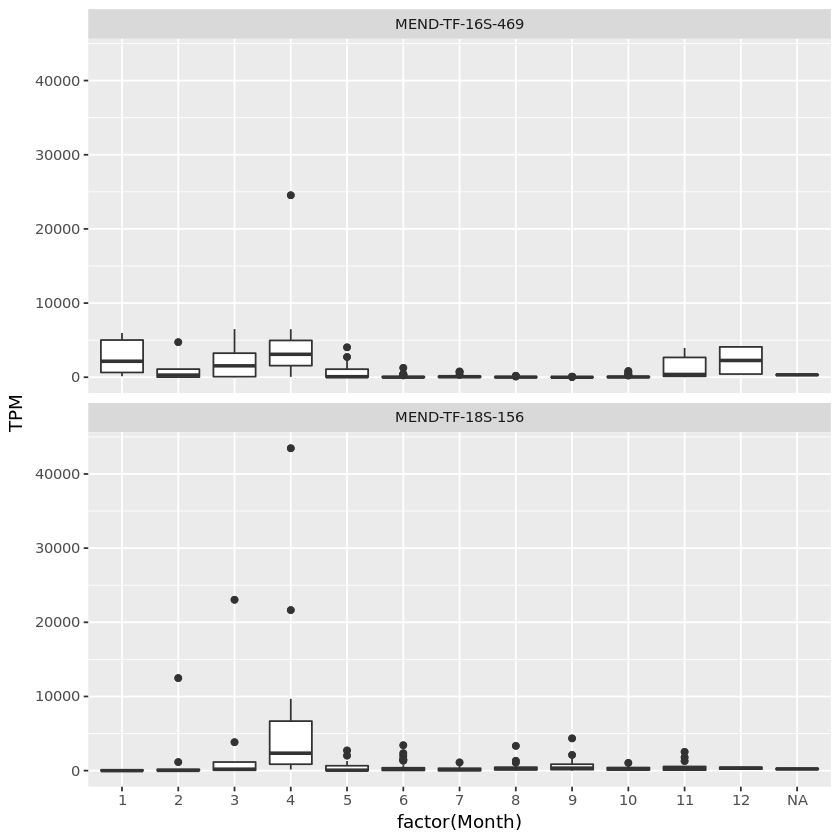

In [156]:
getOurSeason <- function(date) {
    d <- as.POSIXlt(date, format="%d%b%Y")
    if (is.na(date) ) {
        return("")
    }
    if (grepl("D",date) & !grepl("Dec",date)) {
        date = unlist(strsplit(date,"D"))[1]
    }
    if (grepl("Mendota",date)) {
        return("")
    }
    
    curr_year = format(as.Date(d,format="%d%b%Y"),"%Y")
    WS <- as.POSIXlt(paste0(as.character(curr_year),"-12-15"), format = "%Y-%m-%d") # Winter Solstice
    SE <- as.POSIXlt(paste0(as.character(curr_year),"-03-15"),  format = "%Y-%m-%d") # Spring Equinox
    SS <- as.POSIXlt(paste0(as.character(curr_year),"-06-15"),  format = "%Y-%m-%d") # Summer Solstice
    FE <- as.POSIXlt(paste0(as.character(curr_year),"-09-15"),  format = "%Y-%m-%d") # Fall Equinox

    if (is.na(d$yday) | is.na(WS$yday) | is.na(SE$yday) | is.na(FE$yday) | is.na(SS$yday)) {
        return("NoSeason")
    }
    if (((d$yday >= WS$yday) & (d$yday < SE$yday)) | (d$yday < SE$yday)) {
        return("Winter")
    } else if ((d$yday >= SE$yday) & (d$yday < SS$yday)) {
        return("Spring")
    } else if ((d$yday >= SS$yday) & (d$yday < FE$yday)) {
        return("Summer")
    } else {
        return("Fall")
    }
}

ggplot((sam_with_meta_filt %>% dplyr::filter(Label=="MEND-TF-18S-156") %>%
       dplyr::mutate(Month = month(as.Date(SampleDate,format="%d%b%Y")))) %>%
       dplyr::bind_rows((sam_with_meta_bact_filt %>% dplyr::filter(Label=="MEND-TF-16S-469") %>%
       dplyr::mutate(Month = month(as.Date(SampleDate,format="%d%b%Y"))))))+ 
           #Season = unlist(lapply(SampleDate,getOurSeason)))) + 
    geom_boxplot(aes(x=factor(Month),y=TPM)) + facet_wrap(~Label,nrow=2)

`summarise()` has grouped output by 'Month', 'Year'. You can override using the `.groups` argument.



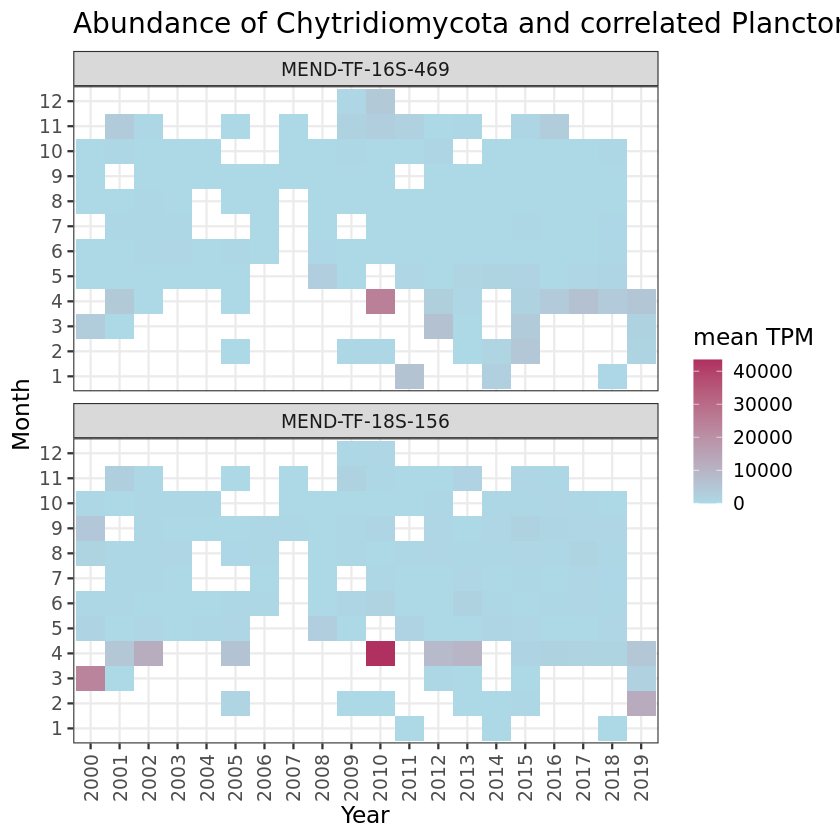

In [189]:
ggplot((sam_with_meta_filt %>% dplyr::filter(Label=="MEND-TF-18S-156") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")))) %>%
       dplyr::bind_rows((sam_with_meta_bact_filt %>% dplyr::filter(Label=="MEND-TF-16S-469")))%>%
       dplyr::filter(!is.na(SampleDate) & (SampleDate != "Control")) %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")),
                     Month = month(as.Date(SampleDate,format="%d%b%Y"))) %>%
    dplyr::select(Year,Month,SampleDate,Label,TPM) %>%
    dplyr::group_by(Month,Year,Label) %>% dplyr::summarize(meanTPM=mean(TPM,na.rm=T),
                                                           stTPM=sd(TPM,na.rm=T))) + 
    geom_tile(aes(x=factor(Year),y=factor(Month),fill=meanTPM)) +
    scale_fill_gradient(low="light blue",high="maroon",name="mean TPM") + theme_bw(base_size=14) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + facet_wrap(~Label,nrow=2) + 
    ylab("Month") + xlab("Year") + ggtitle("Abundance of Chytridiomycota and correlated Planctomycete")
    #geom_point(aes(x=Year,y=meanTPM,color=factor(Month)),size=3)+scale_color_manual(values=distinct_cols)

ggsave("../../figures/chytrid_plancto.png",width=8,height=10,units="in",dpi=400)

Warning message:
“Removed 12 rows containing missing values (stat_boxplot).”


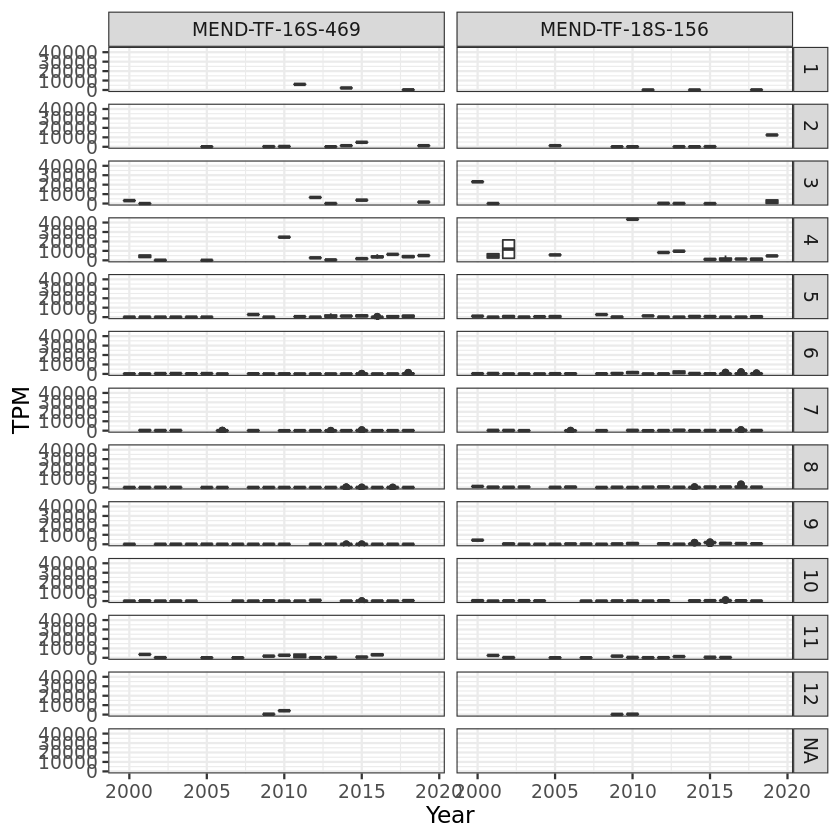

In [173]:
ggplot((sam_with_meta_filt %>% dplyr::filter(Label=="MEND-TF-18S-156") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")))) %>%
       dplyr::bind_rows((sam_with_meta_bact_filt %>% dplyr::filter(Label=="MEND-TF-16S-469")))%>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")),
                     Month = month(as.Date(SampleDate,format="%d%b%Y"))) %>%
    dplyr::select(Year,Month,SampleDate,Label,TPM)) +
    geom_boxplot(aes(x=Year,y=TPM,group=factor(Year))) + facet_grid(cols=vars(Label), rows=vars(Month)) +
    theme_bw(base_size=12)

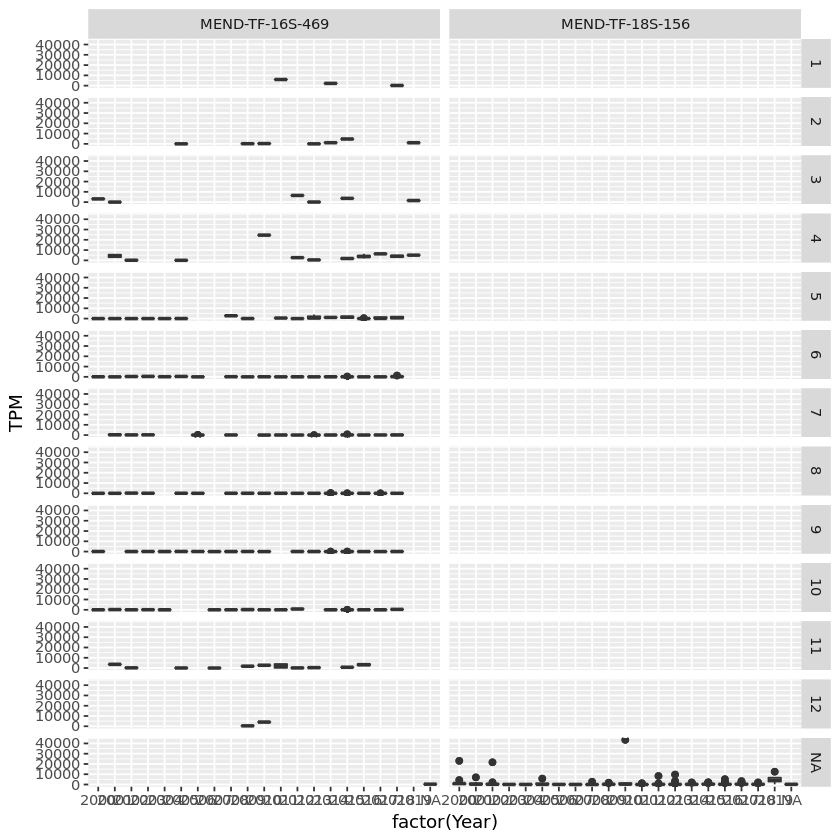

In [164]:
ggplot((sam_with_meta_filt %>% dplyr::filter(Label=="MEND-TF-18S-156") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")))) %>%
       dplyr::bind_rows((sam_with_meta_bact_filt %>% dplyr::filter(Label=="MEND-TF-16S-469") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")),
                     Month = month(as.Date(SampleDate,format="%d%b%Y"))))))+ 
           #Season = unlist(lapply(SampleDate,getOurSeason)))) + 
    geom_boxplot(aes(x=factor(Year),y=TPM)) + facet_grid(cols=vars(Label), rows=vars(Month))

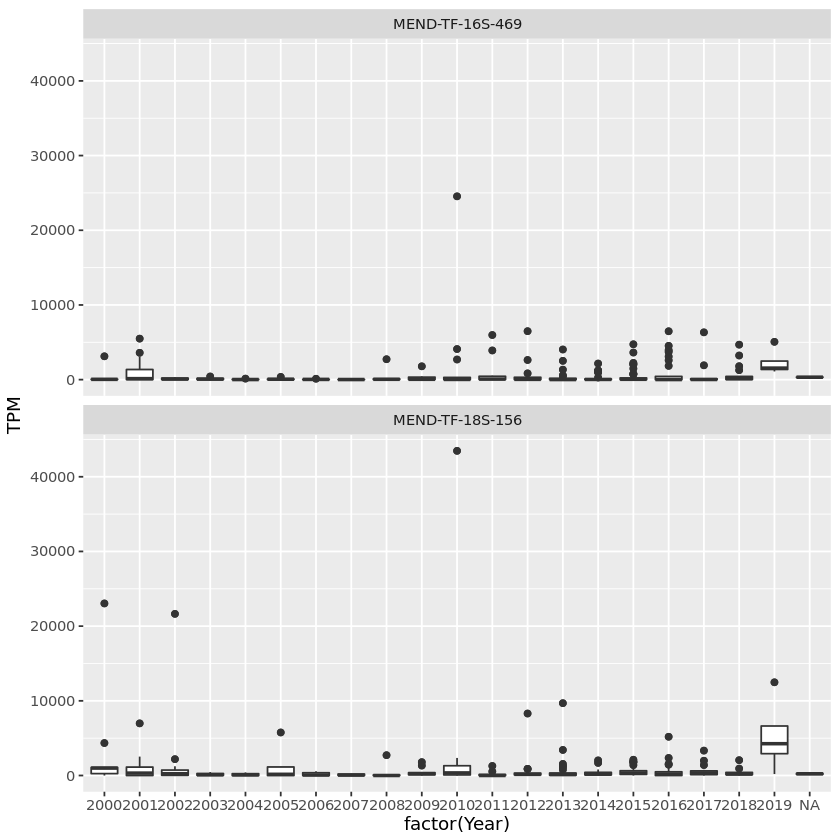

In [157]:
ggplot((sam_with_meta_filt %>% dplyr::filter(Label=="MEND-TF-18S-156") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y")))) %>%
       dplyr::bind_rows((sam_with_meta_bact_filt %>% dplyr::filter(Label=="MEND-TF-16S-469") %>%
       dplyr::mutate(Year = year(as.Date(SampleDate,format="%d%b%Y"))))))+ 
           #Season = unlist(lapply(SampleDate,getOurSeason)))) + 
    geom_boxplot(aes(x=factor(Year),y=TPM)) + facet_wrap(~Label,nrow=2)

## Ochrophyte associates

In [78]:
#MEND−TF−16S−503, 882
euk_bact_edge_frame %>% dplyr::filter(.head == "MEND-TF-16S-921")%>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::select(.head,.tail,BactOrder,BactPhylum,CorrCoef,BactFamily,Phylum1,Phylum2,Class1,Order2,Class2) 

.head,.tail,BactOrder,BactPhylum,CorrCoef,BactFamily,Phylum1,Phylum2,Class1,Order2,Class2
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MEND-TF-16S-921,MEND-TF-18S-121,Rickettsiales,Proteobacteria,0.5683481,Rickettsiaceae,Rotifera,Proteobacteria,Alphaproteobacteria,Ploima,Eurotatoria
MEND-TF-16S-921,MEND-TF-18S-134,Rickettsiales,Proteobacteria,0.5069400,Rickettsiaceae,Alveolata,Proteobacteria,Alphaproteobacteria,Thoracosphaerales,Dinophyceae
MEND-TF-16S-921,MEND-TF-18S-295,Rickettsiales,Proteobacteria,0.5718979,Rickettsiaceae,Ciliophora,Proteobacteria,Alphaproteobacteria,Ciliophora incertae sedis,Ciliophora incertae sedis
MEND-TF-16S-921,MEND-TF-18S-121,Rickettsiales,Proteobacteria,0.5683481,Rickettsiaceae,Rotifera,Proteobacteria,Alphaproteobacteria,Ploima,Eurotatoria
MEND-TF-16S-921,MEND-TF-18S-134,Rickettsiales,Proteobacteria,0.5069400,Rickettsiaceae,Alveolata,Proteobacteria,Alphaproteobacteria,Thoracosphaerales,Dinophyceae
MEND-TF-16S-921,MEND-TF-18S-295,Rickettsiales,Proteobacteria,0.5718979,Rickettsiaceae,Ciliophora,Proteobacteria,Alphaproteobacteria,Ciliophora incertae sedis,Ciliophora incertae sedis


In [192]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Ochrophyta") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,.tail,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,.tail,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1008,MEND-TF-18S-133,Synechococcales,Cyanobacteria,0.8698393,Chamaesiphonaceae,2
MEND-TF-16S-103,MEND-TF-18S-133,Verrucomicrobiales,Verrucomicrobia,0.5239673,Verrucomicrobia subdivision 3,2
MEND-TF-16S-1097,MEND-TF-18S-232,Synechococcales,Cyanobacteria,0.9828334,Chamaesiphonaceae,2
MEND-TF-16S-148,MEND-TF-18S-130,Opitutales,Verrucomicrobia,0.5362860,Opitutaceae,2
MEND-TF-16S-370,MEND-TF-18S-133,Rickettsiales,Proteobacteria,0.7159230,Anaplasmataceae,2
MEND-TF-16S-638,MEND-TF-18S-130,Terrimicrobiales,Verrucomicrobia,0.6104709,Terrimicrobiaceae,2
MEND-TF-16S-83,MEND-TF-18S-133,Spirochaetales,Spirochaetes,0.7495212,Borreliaceae,2
MEND-TF-16S-834,MEND-TF-18S-130,Flavobacteriales,Bacteroidetes,0.5170761,Flavobacteriaceae,2
MEND-TF-16S-896,MEND-TF-18S-239,Pirellulales,Planctomycetes,0.5449305,Pirellulaceae,2


In [26]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Haptophyta") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1086,Synechococcales,Cyanobacteria,0.8666151,Chamaesiphonaceae,2


In [43]:
euk_bact_edge_frame %>% dplyr::filter(.head == "MEND-TF-16S-1086")

.tail,.head,P.vals,PValRank,Corrected,CorrCoef,Seq2_res,Seq1_res,Phylum1,Domain1,⋯,Class1,Dom2,Order2,Class2,from.x,from.y,LinkPhylum,BaseColor,to.x,to.y
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
MEND-TF-18S-143,MEND-TF-16S-1086,0,172,0.0001188495,0.5840866,MEND-TF-16S-1086,MEND-TF-18S-143,Alveolata,Eukaryota,⋯,,Eukaryota,Gymnodiniales,Dinophyceae,4.975825,17.75082,Bacterial,Euk-Bact,-18.45488,18.67821
MEND-TF-18S-182,MEND-TF-16S-1086,0,201,0.0001388881,0.8666151,MEND-TF-16S-1086,MEND-TF-18S-182,Haptophyta,Eukaryota,⋯,,Eukaryota,Prymnesiales,Prymnesiophyceae,4.975825,17.75082,Bacterial,Euk-Bact,-11.91069,-23.62572
MEND-TF-18S-143,MEND-TF-16S-1086,0,4997,0.0034528554,0.5840866,MEND-TF-18S-143,MEND-TF-16S-1086,Alveolata,Eukaryota,⋯,,Eukaryota,Gymnodiniales,Dinophyceae,4.975825,17.75082,Bacterial,Euk-Bact,-18.45488,18.67821
MEND-TF-18S-182,MEND-TF-16S-1086,0,4998,0.0034535464,0.8666151,MEND-TF-18S-182,MEND-TF-16S-1086,Haptophyta,Eukaryota,⋯,,Eukaryota,Prymnesiales,Prymnesiophyceae,4.975825,17.75082,Bacterial,Euk-Bact,-11.91069,-23.62572


In [190]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Cercozoa") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1033,Sphingomonadales,Proteobacteria,0.5286888,Sphingosinicellaceae,2
MEND-TF-16S-1136,Rhodobacterales,Proteobacteria,0.5555878,Rhodobacteraceae,2
MEND-TF-16S-217,Verrucomicrobiales,Verrucomicrobia,0.5334010,Verrucomicrobiaceae,2
MEND-TF-16S-217,Verrucomicrobiales,Verrucomicrobia,0.5344463,Verrucomicrobiaceae,2
MEND-TF-16S-242,Solirubrobacterales,Actinobacteria,0.5581172,Conexibacteraceae,2
MEND-TF-16S-412,Terrimicrobiales,Verrucomicrobia,0.5164138,Terrimicrobiaceae,2
MEND-TF-16S-412,Terrimicrobiales,Verrucomicrobia,0.5234361,Terrimicrobiaceae,2
MEND-TF-16S-568,Gemmatimonadales,Gemmatimonadetes,0.5572500,Gemmatimonadaceae,2
MEND-TF-16S-617,Sporichthyales,Actinobacteria,0.5267759,Sporichthyaceae,2


In [159]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Alveolata") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1033,Sphingomonadales,Proteobacteria,0.6657438,Sphingosinicellaceae,2
MEND-TF-16S-1037,Phycisphaerales,Planctomycetes,0.5805067,Phycisphaeraceae,2
MEND-TF-16S-1086,Synechococcales,Cyanobacteria,0.5840866,Chamaesiphonaceae,2
MEND-TF-16S-1136,Rhodobacterales,Proteobacteria,0.5363211,Rhodobacteraceae,2
MEND-TF-16S-1156,Rhodobacterales,Proteobacteria,0.5704337,Rhodobacteraceae,2
MEND-TF-16S-311,Planctomycetales,Planctomycetes,0.6661688,Planctomycetaceae,2
MEND-TF-16S-452,Chitinophagales,Bacteroidetes,0.5128816,Chitinophagaceae,2
MEND-TF-16S-503,Pirellulales,Planctomycetes,0.7042753,Pirellulaceae,2
MEND-TF-16S-541,Flavobacteriales,Bacteroidetes,0.5324217,Crocinitomicaceae,2


In [68]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Stramenopiles") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-156,Sphingomonadales,Proteobacteria,0.8223532,Erythrobacteraceae,2
MEND-TF-16S-996,Rhodospirillales,Proteobacteria,0.5669029,Rhodospirillaceae,2
MEND-TF-16S-996,Rhodospirillales,Proteobacteria,0.7113424,Rhodospirillaceae,2


In [158]:
euk_bact_edge_frame %>% dplyr::filter(Phylum1 == "Ciliophora") %>%
    dplyr::left_join(data_tree_bact %>% dplyr::rename(c("BactOrder"="Order",
                                                           "BactFamily" = "Family",
                                                           "BactPhylum"="Phylum")),
                     by=c(".head"="Label")) %>%
    dplyr::group_by(.head,BactOrder,BactPhylum,CorrCoef,BactFamily) %>% dplyr::tally() %>% dplyr::arrange(.head)

.head,BactOrder,BactPhylum,CorrCoef,BactFamily,n
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
MEND-TF-16S-1000,Pseudanabaenales,Cyanobacteria,0.5471538,Prochlorotrichaceae,2
MEND-TF-16S-1008,Synechococcales,Cyanobacteria,0.5878660,Chamaesiphonaceae,2
MEND-TF-16S-1013,Nostocales,Cyanobacteria,0.5823815,Nostocaceae,2
MEND-TF-16S-1029,Sphingomonadales,Proteobacteria,0.5443186,Erythrobacteraceae,2
MEND-TF-16S-1033,Sphingomonadales,Proteobacteria,0.6210561,Sphingosinicellaceae,2
MEND-TF-16S-1146,Chloroflexales,Chloroflexi,0.5496999,Roseiflexineae,2
MEND-TF-16S-1175,Hyphomonadales,Proteobacteria,0.5028187,Hyphomonadaceae,2
MEND-TF-16S-1238,Synechococcales,Cyanobacteria,0.5153695,Chamaesiphonaceae,2
MEND-TF-16S-161,Myxococcales,Proteobacteria,0.5854738,Sandaracinaceae,2


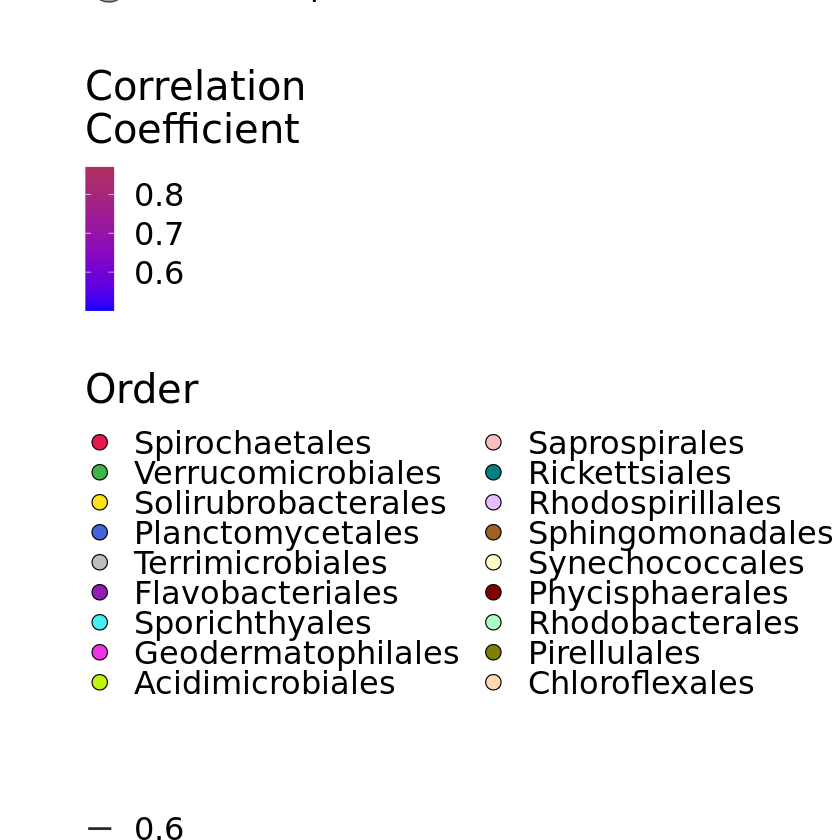

In [49]:
network_main + network_alveolate + 
    plot_layout(guides = 'collect',widths=c(1,0.5))
ggsave("../../figures/combo-network.pdf",width=15,height=15,units="in")

## Supplemental figure: bacteria in common

Joining, by = c("Seq1", "Seq2")

Warning message:
“Removed 293 rows containing non-finite values (stat_count).”


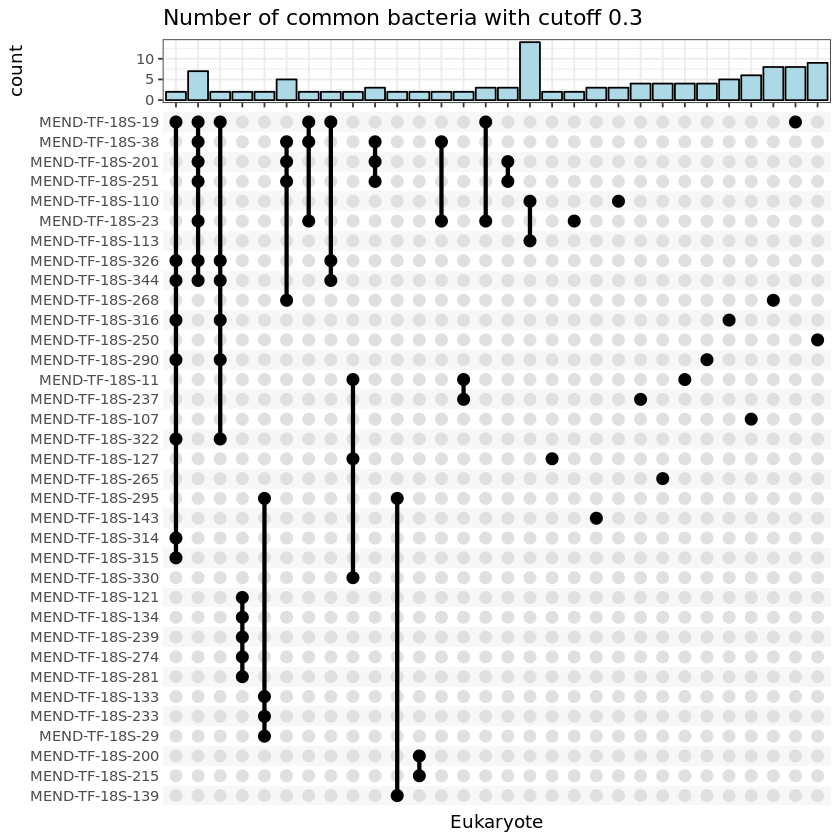

In [51]:
bact_euk_only = significant_correlations %>% dplyr::full_join(corr_coefs) %>%
    dplyr::filter((grepl("16S",Seq1) & grepl("18S",Seq2)) | 
                  (grepl("16S",Seq2) & grepl("18S",Seq1))) %>%
    dplyr::filter(CorrCoef > 0) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Class,Phylum,Domain), by=c("Seq1"="Label")) %>%
    dplyr::rename(c("Order1"="Order","Class1"="Class","Domain1"="Domain","Phylum1"="Phylum")) %>%
    dplyr::left_join(v %>% dplyr::select(Label,Order,Class,Phylum,Domain), by=c("Seq2"="Label")) %>%
    dplyr::rename(c("Order2"="Order","Class2"="Class","Domain2"="Domain","Phylum2"="Phylum")) 

cutoff = 0.3
upsetbact <- bact_euk_only %>%
    #dplyr::filter(CorrCoef > 0.5) %>%
    dplyr::mutate(Bacterium = dplyr::case_when(Domain1 == "Bacteria" ~ Seq1,
                                               TRUE ~ Seq2),
                  Eukaryote = dplyr::case_when(Domain1 == "Eukaryota" ~ Seq1,
                                               TRUE ~ Seq2),
                  EukPhylum = dplyr::case_when(Domain1 == "Eukaryota" ~ Phylum1,
                                               TRUE ~ Phylum2),
                  BacPhylum = dplyr::case_when(Domain1 == "Bacteria" ~ Phylum1,
                                               TRUE ~ Phylum2),
                  BacOrder = dplyr::case_when(Domain1 == "Bacteria" ~ Order1,
                                               TRUE ~ Order2),
                  BacClass = dplyr::case_when(Domain1 == "Bacteria" ~ Class1,
                                               TRUE ~ Class2),
                  Connection = dplyr::case_when((CorrCoef < cutoff)|(Corrected >= 0.05) ~ "<0.4",
                                                CorrCoef <= 0.5 ~ "<=0.5",
                                                CorrCoef <= 0.6 ~ "<=0.6",
                                                CorrCoef <= 0.7 ~ "<=0.7",
                                                CorrCoef <= 0.8 ~ "<=0.8",
                                                CorrCoef <= 0.9 ~ "<=0.9",
                                                CorrCoef <= 1 ~ "<=1"),
                  DichConnection = dplyr::case_when((CorrCoef < cutoff)|(Corrected >= 0.05) ~ "No",
                                                    TRUE ~ "Yes")) %>%
    dplyr::distinct(Bacterium,Eukaryote,.keep_all=TRUE) %>%
    dplyr::group_by(Eukaryote,EukPhylum,BacPhylum,BacOrder,BacClass,DichConnection) %>%
    dplyr::filter((Corrected < 0.05)&(CorrCoef > cutoff)) %>%
    dplyr::group_by(Bacterium) %>% dplyr::summarize(NumCommonPartners=length(unique(Eukaryote)),
                                                    Eukaryote=list(unique(Eukaryote)),
                                                    EukPhylum=list(unique(EukPhylum)),
                                                    BacPhylum=list(unique(BacPhylum)),
                                                    BacOrder=list(unique(BacOrder)),
                                                    BacClass=list(unique(BacClass)))

upsetbact %>%
  ggplot(aes(x=Eukaryote)) + theme_bw() +
    geom_bar(fill="light blue",color="black") +
    scale_x_upset(n_intersections = 30,order_by = "degree",reverse=TRUE) + 
    ggtitle(paste0("Number of common bacteria with cutoff ", cutoff))

## Supplemental figure: community members

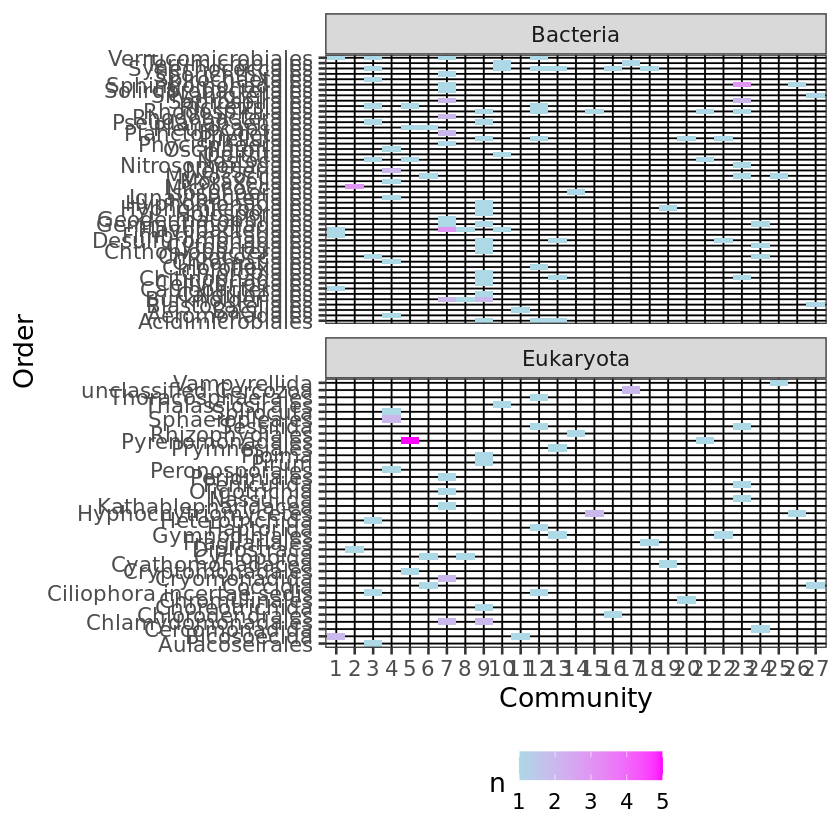

In [52]:
ggplot(euk_bact_layout_frame %>%
                  dplyr::group_by(community,Order,Domain) %>% dplyr::tally()) + 
    geom_hline(aes(yintercept=Order)) + 
    geom_vline(aes(xintercept=factor(community))) + 
    geom_tile(aes(x=factor(community),fill=n,y=Order),stat="identity") +
    scale_fill_gradient(low="light blue", high="magenta") + theme_bw(base_size=16) + 
    facet_wrap(~Domain,ncol=1,scales="free_y") + theme(legend.position="bottom") + xlab("Community")
ggsave("../../figures/community_members.png",dpi=400,height=20,width=10,units="in")